# **Problem Statement:**

- The major objective of this project is to extract actionable insights from the historical match data and make strategic changes to make India win. 
- Primary objective is to create Machine Learning models which correctly predicts a win for the Indian Cricket Team. 
- Once a model is developed then you have to extract actionable insights and recommendation. Also, below are the details of the next 10 matches, India is going to play. You have to predict the result of the matches.


In [4]:
# !pip install optuna
!pip install xgboost

^C


^C


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use("fivethirtyeight")

from sklearn.model_selection import KFold, train_test_split

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import preprocessing
from sklearn import metrics

from xgboost import  XGBClassifier


import optuna

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# If read.excel doesnt work uncomment and run following code.
!pip install xlrd



# **Loading the data**

### Data Dictionary

In [ ]:
df_metadata = pd.read_excel('/content/Sports Data.xlsx', sheet_name = 'Meta data', header = 1, usecols = [1,2])
df_metadata

## Data set

In [ ]:
df_maindata_excel = pd.read_excel('/content/Sports Data.xlsx', sheet_name = 'Sports data for DSBA')
df_maindata_excel.info()

In [6]:
df_maindata_excel["kfold"] = -1

skf = StratifyKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(skf.split(df_maindata_excel, df_maindata_excel.Result)):
    df_maindata_excel.loc[valid_indicies, "kfold"] = fold

df_maindata_excel.to_csv("maindata_folds.csv", index=False)

In [7]:
df_maindata = pd.read_csv('maindata_folds.csv')
df_maindata.head()

,Game_number,Result,Avg_team_Age,Match_light_type,Match_format,Bowlers_in_team,Wicket_keeper_in_team,All_rounder_in_team,First_selection,Opponent,Season,Audience_number,Offshore,Max_run_scored_1over,Max_wicket_taken_1over,Extra_bowls_bowled,Min_run_given_1over,Min_run_scored_1over,Max_run_given_1over,extra_bowls_opponent,player_highest_run,Players_scored_zero,player_highest_wicket,kfold
0,Game_1,Loss,18.0,Day,ODI,3.0,1,3.0,Bowling,Srilanka,Summer,9940.0,No,13.0,3,0.0,2,3.0,6.0,0,54.0,3,1,1
1,Game_2,Win,24.0,Day,T20,3.0,1,4.0,Batting,Zimbabwe,Summer,8400.0,No,12.0,1,0.0,0,3.0,6.0,0,69.0,2,1,4
2,Game_3,Loss,24.0,Day and Night,T20,3.0,1,2.0,Bowling,Zimbabwe,NaN,13146.0,Yes,14.0,4,0.0,0,3.0,6.0,0,69.0,3,1,2
3,Game_4,Win,24.0,NaN,ODI,2.0,1,2.0,Bowling,Kenya,Summer,7357.0,No,15.0,4,0.0,2,3.0,6.0,0,73.0,3,1,3
4,Game_5,Loss,24.0,Night,ODI,1.0,1,3.0,Bowling,Srilanka,Summer,13328.0,No,12.0,4,0.0,0,3.0,6.0,0,80.0,3,1,4


In [8]:
df_maindata.shape

(2930, 24)

In [9]:
df_maindata.describe()

,Avg_team_Age,Bowlers_in_team,Wicket_keeper_in_team,All_rounder_in_team,Audience_number,Max_run_scored_1over,Max_wicket_taken_1over,Extra_bowls_bowled,Min_run_given_1over,Min_run_scored_1over,Max_run_given_1over,extra_bowls_opponent,player_highest_run,kfold
count,2833.000000,2848.000000,2930.0,2890.000000,2.849000e+03,2902.000000,2930.000000,2901.000000,2930.000000,2903.000000,2896.000000,2930.000000,2902.000000,2930.000000
mean,29.242852,2.913624,1.0,2.722491,4.626796e+04,15.199862,2.713993,11.252671,1.952560,2.762659,8.669199,4.229693,65.889387,2.000000
std,2.264230,1.023907,0.0,1.092699,4.859958e+04,3.661010,1.080623,7.780829,1.678332,0.705759,5.003525,3.626108,20.331614,1.414455
min,12.000000,1.000000,1.0,1.000000,7.063000e+03,11.000000,1.000000,0.000000,0.000000,1.000000,6.000000,0.000000,30.000000,0.000000
25%,30.000000,2.000000,1.0,2.000000,2.036300e+04,12.000000,2.000000,6.000000,0.000000,2.000000,6.000000,2.000000,48.000000,1.000000
50%,30.000000,3.000000,1.0,3.000000,3.434900e+04,14.000000,3.000000,10.000000,2.000000,3.000000,6.000000,3.000000,66.000000,2.000000
75%,30.000000,4.000000,1.0,4.000000,5.787600e+04,18.000000,4.000000,15.000000,3.000000,3.000000,9.250000,7.000000,84.000000,3.000000
max,70.000000,5.000000,1.0,4.000000,1.399930e+06,25.000000,4.000000,40.000000,6.000000,4.000000,40.000000,18.000000,100.000000,4.000000


In [10]:
df_maindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Game_number             2930 non-null   object 
 1   Result                  2930 non-null   object 
 2   Avg_team_Age            2833 non-null   float64
 3   Match_light_type        2878 non-null   object 
 4   Match_format            2860 non-null   object 
 5   Bowlers_in_team         2848 non-null   float64
 6   Wicket_keeper_in_team   2930 non-null   int64  
 7   All_rounder_in_team     2890 non-null   float64
 8   First_selection         2871 non-null   object 
 9   Opponent                2894 non-null   object 
 10  Season                  2868 non-null   object 
 11  Audience_number         2849 non-null   float64
 12  Offshore                2866 non-null   object 
 13  Max_run_scored_1over    2902 non-null   float64
 14  Max_wicket_taken_1over  2930 non-null   

Observations:

---


- There are missing values. Check them and treat them accordingly
- Player_hightest_wicket and Players_scored_zero is object type convert it into int as it might be useful as int


In [11]:
"""Making columns lower case and replacing any spaces with '_'"""
df_maindata.columns = df_maindata.columns.str.lower().str.replace(' ', '_')

## **Check unique values and convert required columns into Integer type:**

---


- Check the unique values 
- If all values are int then we change it to integer
- Else we convert any string values to int and then convert all values into int type.

In [12]:
for col in df_maindata.columns:
  print(col, '\n',df_maindata[col].unique())
  print()

game_number 
 ['Game_1' 'Game_2' 'Game_3' ... 'Game_2928' 'Game_2929' 'Game_2930']

result 
 ['Loss' 'Win']

avg_team_age 
 [18. 24. nan 17. 12. 25. 26. 27. 28. 29. 30. 70. 69. 50.]

match_light_type 
 ['Day' 'Day and Night' nan 'Night']

match_format 
 ['ODI' 'T20' 'Test' '20-20' nan]

bowlers_in_team 
 [ 3.  2.  1. nan  4.  5.]

wicket_keeper_in_team 
 [1]

all_rounder_in_team 
 [ 3.  4.  2.  1. nan]

first_selection 
 ['Bowling' 'Batting' 'Bat' nan]

opponent 
 ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England' 'South Africa'
 'Pakistan' 'West Indies' 'Bangladesh' nan]

season 
 ['Summer' nan 'Winter' 'Rainy']

audience_number 
 [ 9940.  8400. 13146. ... 20937. 28756. 14007.]

offshore 
 ['No' 'Yes' nan]

max_run_scored_1over 
 [13. 12. 14. 15. 16. 19. 21. 22. 25. 18. 11. 17. 24. 20. nan 23.]

max_wicket_taken_1over 
 [3 1 4 2]

extra_bowls_bowled 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 17. 31. 13. 26. 24.
 22. 19. 23. 14. 15. 29. 28. 21. 25. 20. 16. 37. 38. 30. 40.

### **Observations:**

---


- Variables like player_highest_wicket, players_scored_zero, match_format, first_selection has repeated unique values. 
- E.g. player_highest_wicket has 'Three' and 3, which actually means the same. Hence, we will replace 'Three' by 3.
- Similarly for the other variables.
- Finally convert player_hightest_wicket and players_scored_zero to integer

In [ ]:
"""Replacing repeated values"""

df_maindata['player_highest_wicket'] = df_maindata['player_highest_wicket'].apply(lambda x: x if (x != 'Three') else 3)
df_maindata['players_scored_zero'] = df_maindata['players_scored_zero'].apply(lambda x: x if (x != 'Three') else 3)
df_maindata['match_format'] = df_maindata['match_format'].apply(lambda x: x if (x != '20-20') else 'T20')
df_maindata['first_selection'] = df_maindata['first_selection'].apply(lambda x: x if (x != 'Bat') else 'Batting')


"""Converting player_highest_wicket and players_scored_zero to integer"""
df_maindata['player_highest_wicket'] = df_maindata['player_highest_wicket'].astype('int')
df_maindata['players_scored_zero'] = df_maindata['players_scored_zero'].astype('int')

for col in df_maindata.columns:
  print(col, '\n',df_maindata[col].unique())
  print()

game_number 
 ['Game_1' 'Game_2' 'Game_3' ... 'Game_2928' 'Game_2929' 'Game_2930']

result 
 ['Loss' 'Win']

avg_team_age 
 [18. 24. nan 17. 12. 25. 26. 27. 28. 29. 30. 70. 69. 50.]

match_light_type 
 ['Day' 'Day and Night' nan 'Night']

match_format 
 ['ODI' 'T20' 'Test' nan]

bowlers_in_team 
 [ 3.  2.  1. nan  4.  5.]

wicket_keeper_in_team 
 [1]

all_rounder_in_team 
 [ 3.  4.  2.  1. nan]

first_selection 
 ['Bowling' 'Batting' nan]

opponent 
 ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England' 'South Africa'
 'Pakistan' 'West Indies' 'Bangladesh' nan]

season 
 ['Summer' nan 'Winter' 'Rainy']

audience_number 
 [ 9940.  8400. 13146. ... 20937. 28756. 14007.]

offshore 
 ['No' 'Yes' nan]

max_run_scored_1over 
 [13. 12. 14. 15. 16. 19. 21. 22. 25. 18. 11. 17. 24. 20. nan 23.]

max_wicket_taken_1over 
 [3 1 4 2]

extra_bowls_bowled 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 17. 31. 13. 26. 24.
 22. 19. 23. 14. 15. 29. 28. 21. 25. 20. 16. 37. 38. 30. 40. 18. 36. 34.
 

In [ ]:
df_maindata.isnull().sum().to_frame().rename({0: 'Missing Values'}, axis = 1).sort_values(by = 'Missing Values', ascending = False).style.background_gradient('copper_r')

,Missing Values
avg_team_age,97
bowlers_in_team,82
audience_number,81
match_format,70
offshore,64
season,62
first_selection,59
match_light_type,52
all_rounder_in_team,40
opponent,36


,%age of Missing Values
avg_team_age,0.033110
bowlers_in_team,0.027990
audience_number,0.027650
match_format,0.023890
offshore,0.021840
season,0.021160
first_selection,0.020140
match_light_type,0.017750
all_rounder_in_team,0.013650
opponent,0.012290


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



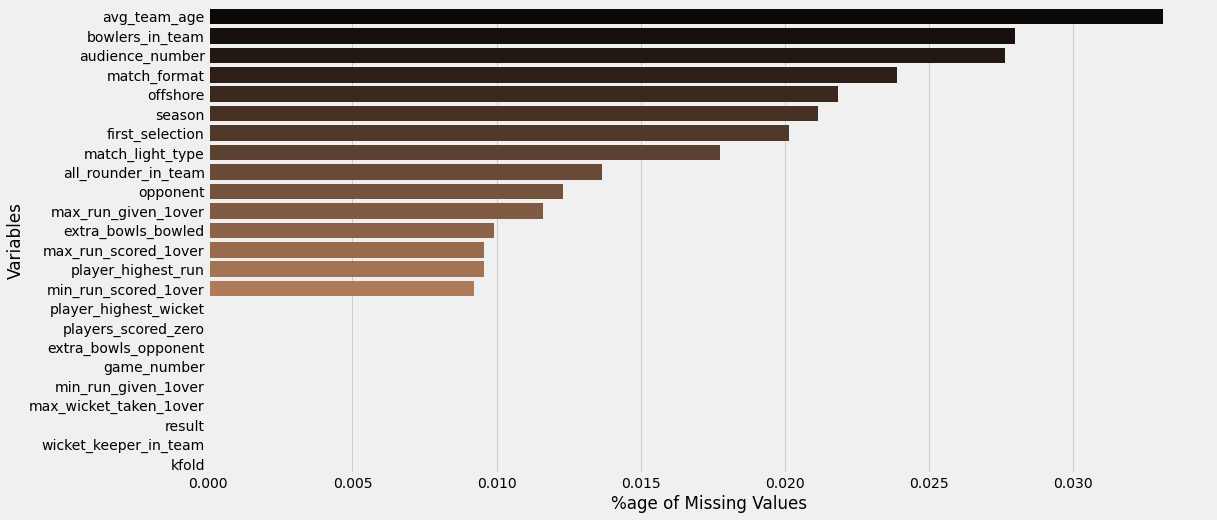

In [ ]:
"""Percentage of Missing Values"""
percentage = df_maindata.isnull().mean().round(5).to_frame().rename({0: '%age of Missing Values'}, axis = 1).sort_values(by = '%age of Missing Values', ascending = False)
display(percentage.style.background_gradient('copper_r'))

"""Setting for displaying plot"""
plot_percentage = percentage.reset_index().rename({"index": "Variables"}, axis = 1)
# order = percentage.isnull().mean().round(2).sort_values(ascending =False).index
ax = sns.barplot(plot_percentage['%age of Missing Values'], plot_percentage['Variables'], palette = 'copper')
plt.show()

Observations:
- Missing values in Avg_team_Age, Bowlers_in_team, Audience_number,Match_format ,Offshore, Season,First_selection, Match_light_type ,All_rounder_in_team, Opponent,Max_run_given_1over, Extra_bowls_bowled,player_highest_run,Max_run_scored_1over, Min_run_scored_1over Treat them accordingly
- Avg_team_Age has highest number of missing values.
- **Missing value in Opponent cannot be filled with mode as it might bias our result towards. Best option is to drop those rows**

In [ ]:
missing_values_cols = list(plot_percentage[plot_percentage['%age of Missing Values'] != 0]['Variables']) 
missing_cat_cols = [col for col in missing_values_cols if df_maindata[col].dtype == 'object']
missing_num_cols = [col for col in missing_values_cols if col not in missing_cat_cols]
missing_cat_cols

['match_format',
 'offshore',
 'season',
 'first_selection',
 'match_light_type',
 'opponent']

In [ ]:
"""Drop rows with missing values in Opponent"""
df_maindata.dropna(subset=['opponent'], inplace = True)

# Now removing Opponent col from list of categorical colummns
missing_cat_cols.remove('opponent')                     

"""Impute Mode for categorical columns"""
for col in missing_cat_cols:
    df_maindata[col].fillna(value=df_maindata[col].mode()[0],inplace=True)

"""Impute mean for numerical columns"""
for col in missing_num_cols:
    df_maindata[col].fillna(value=df_maindata[col].median(),inplace=True)

In [ ]:
df_maindata.isnull().sum().to_frame().rename({0: 'Missing Values'}, axis = 1).sort_values(by = 'Missing Values', ascending = False).style.background_gradient('copper_r')

,Missing Values
game_number,0
result,0
player_highest_wicket,0
players_scored_zero,0
player_highest_run,0
extra_bowls_opponent,0
max_run_given_1over,0
min_run_scored_1over,0
min_run_given_1over,0
extra_bowls_bowled,0


Observations:
- Dropped the rows with missing values in Opponent Col 
- Imputed categorical missing values using mode
- Imputed numerical missing values using mean

## **Duplicates?**

In [ ]:
df_maindata.duplicated().sum()

0

## **Any Constant Features? They show same value or just one value for all the records in the dataset.**

In [ ]:
# Checking constant variables
constant_features = [col for col in df_maindata.columns if df_maindata[col].nunique() == 1]
constant_features

['wicket_keeper_in_team']

In [ ]:
# Dropping the constant feature
del df_maindata['wicket_keeper_in_team']

## **Correlation**

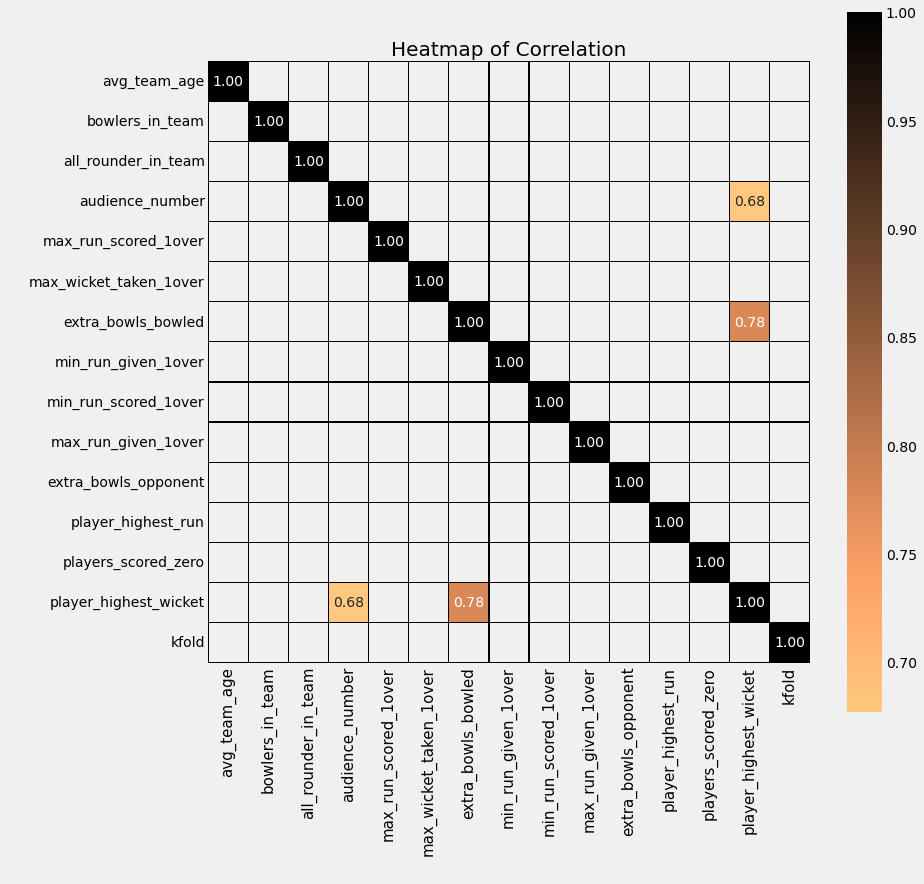

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.heatmap(df_maindata.corr(), annot = True, fmt='.2f', mask = df_maindata.corr() < .65, square = True, lw=0.2,linecolor='black' , cmap = 'copper_r')
plt.title("Heatmap of Correlation",fontsize = 20)
plt.xlabel(" ")
plt.ylabel(" ")
plt.xticks(fontsize = 15)
plt.show();

Observations:
- Wicket_keeper_in_team has only one value. Hence we can drop that variable
- Multicollinearity exists between player_highest_wicket and (audience number and extra bowls bowled) at 0.65 as threshold.
- Drop audience number and extra bowls bowled

In [ ]:
df_maindata.drop(['audience_number', 'extra_bowls_bowled'], axis = 1, inplace=True)

## **Plotting Categorical Fetures**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



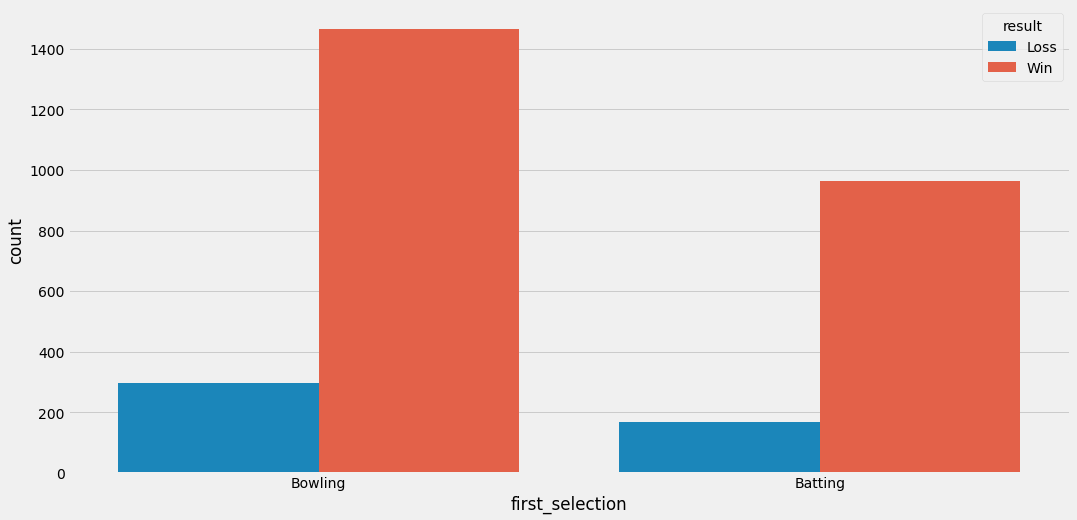

In [ ]:
sns.countplot('first_selection', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



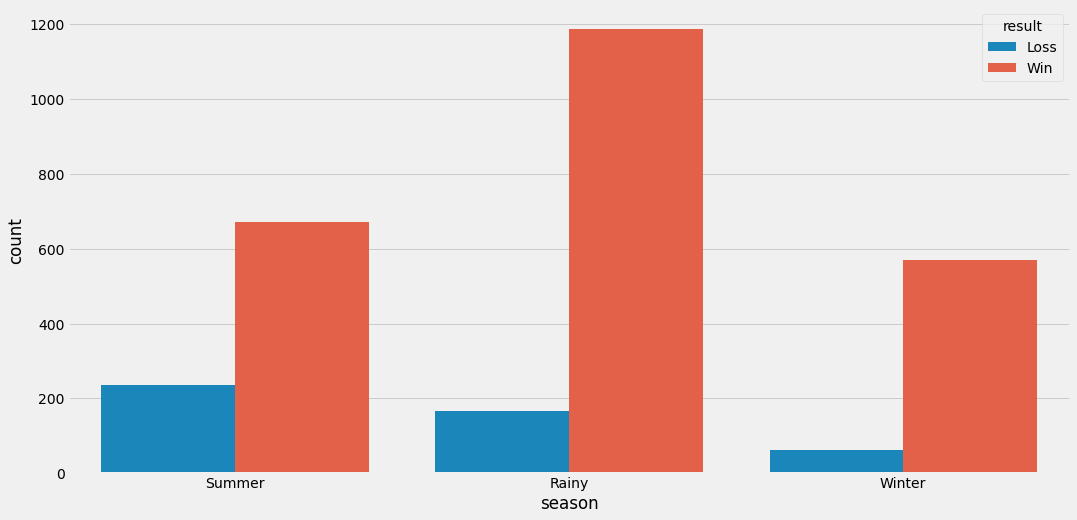

In [ ]:
sns.countplot('season', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



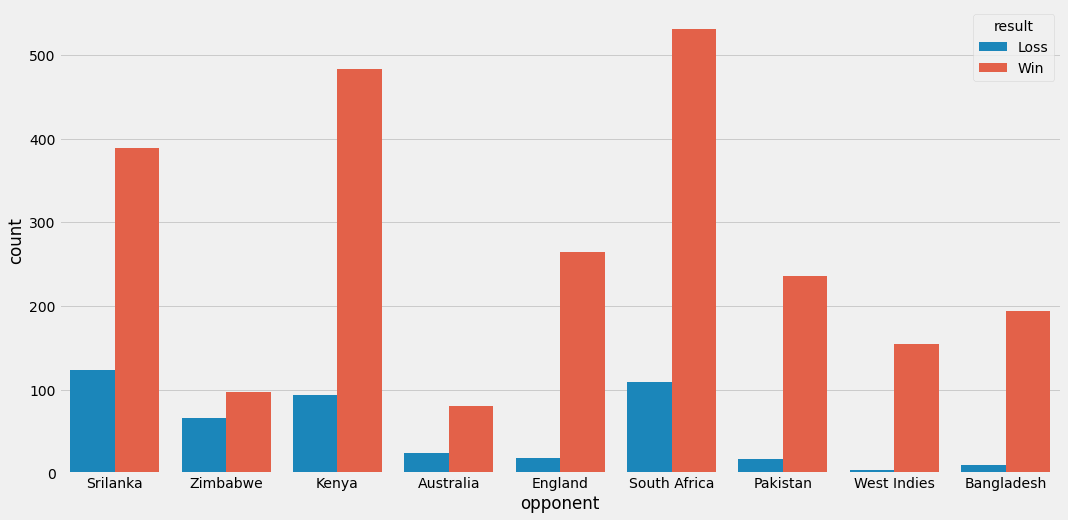

In [ ]:
sns.countplot('opponent', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



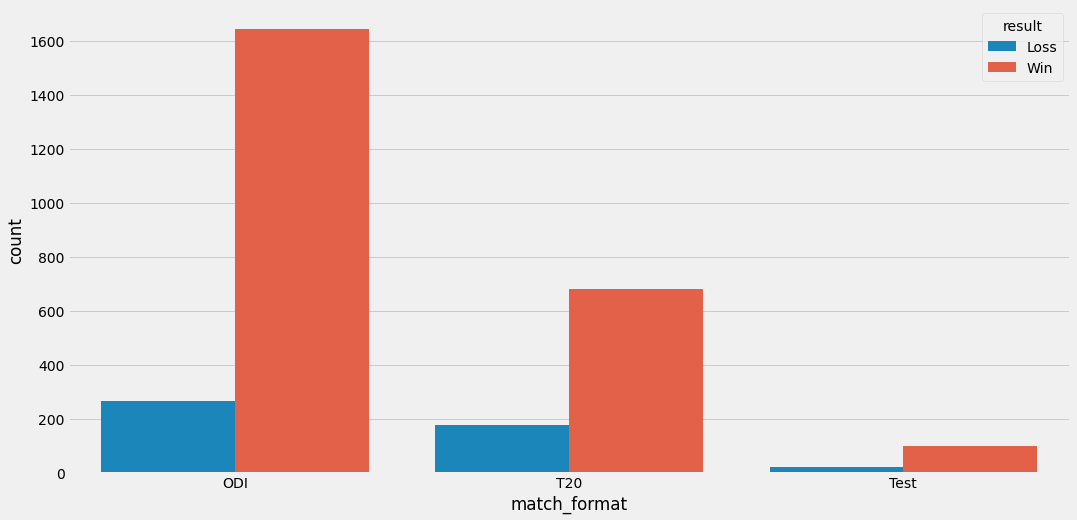

In [ ]:
sns.countplot('match_format', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



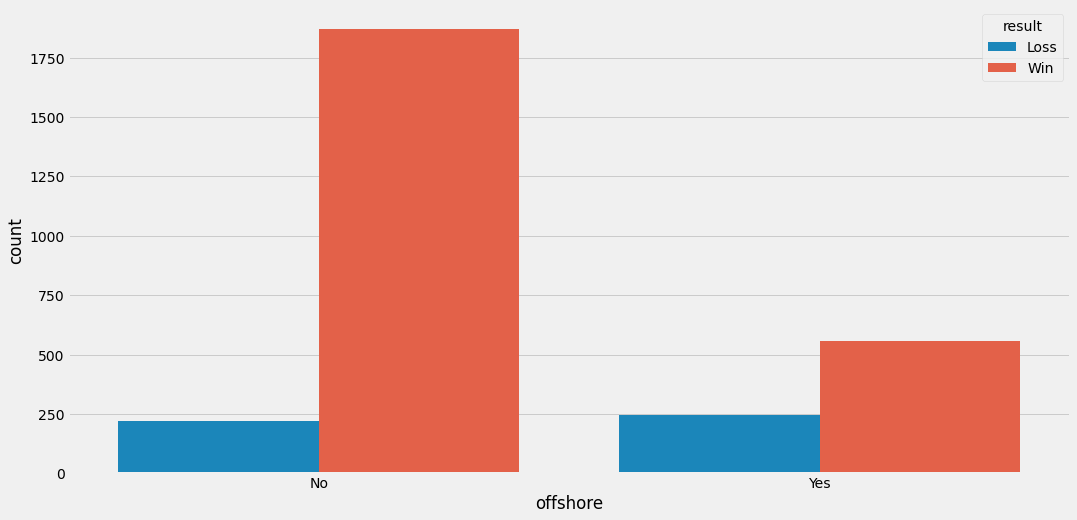

In [ ]:
sns.countplot('offshore', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



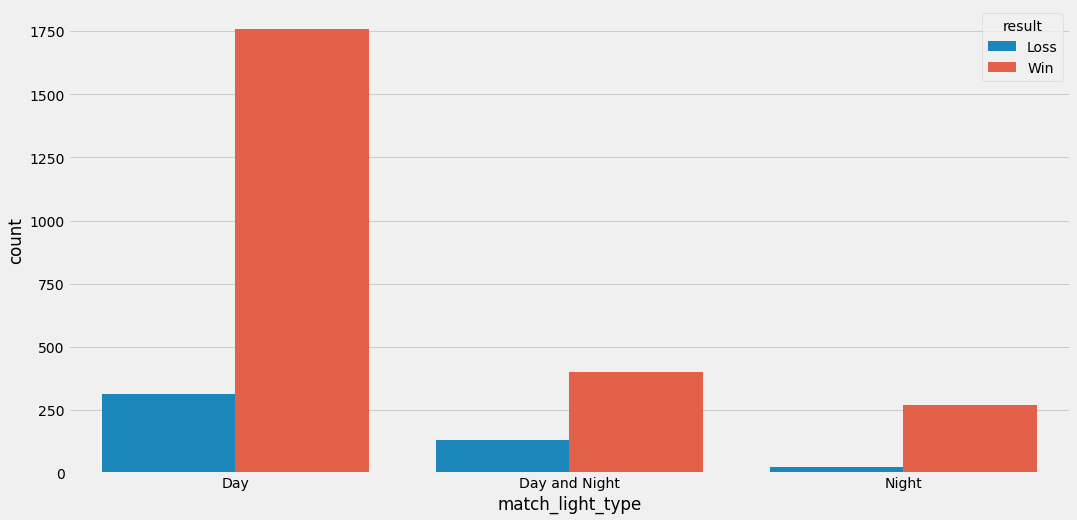

In [ ]:
sns.countplot('match_light_type', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



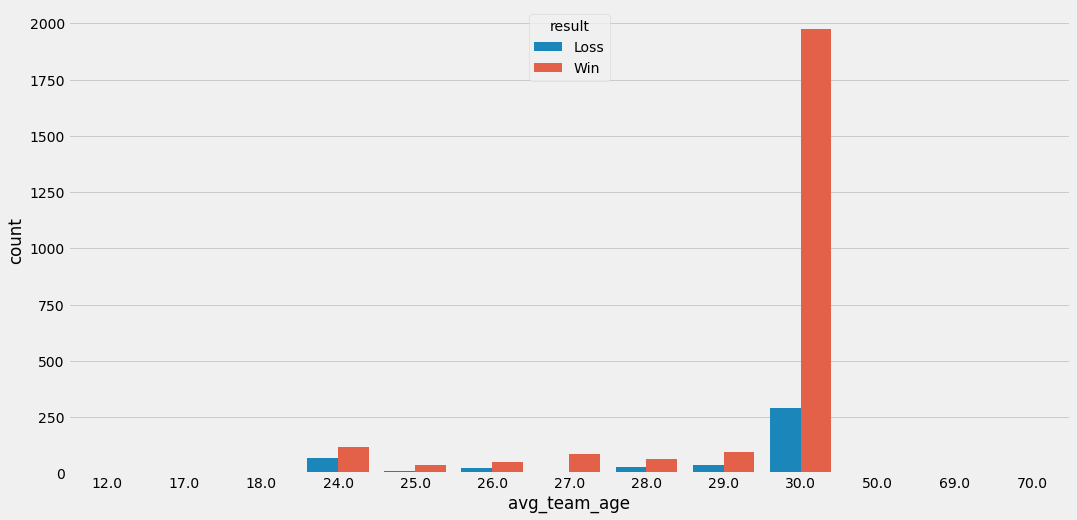

In [ ]:
sns.countplot('avg_team_age', hue = 'result' , data = df_maindata)
plt.show()

Observation:
- avg_age_team has outliers. Average age for any team cannot be 12 or 70. Either its a mistake or outliers.
- India win most matches in avg_age 30. 
- Day time matches are beneficial for us.

### **Treating the outliers**
- **Capping and Flooring the outliers**



In [ ]:
percentiles = df_maindata['avg_team_age'].quantile([0.01, 0.99]).values
df_maindata['avg_team_age'] = np.clip(df_maindata['avg_team_age'], percentiles[0], percentiles[1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



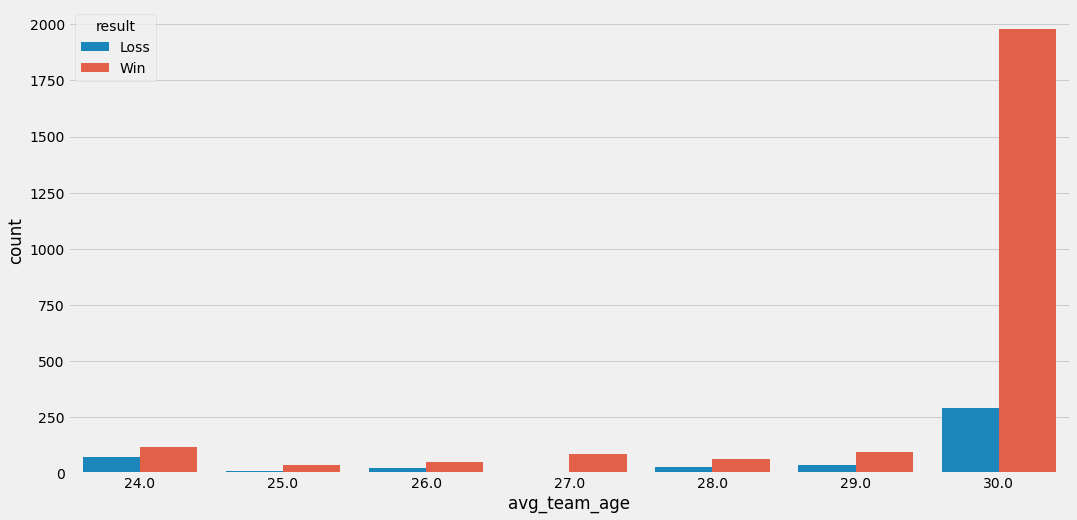

In [ ]:
sns.countplot('avg_team_age', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

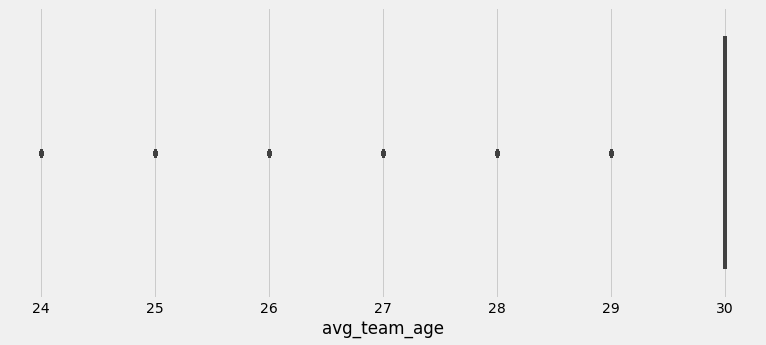

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

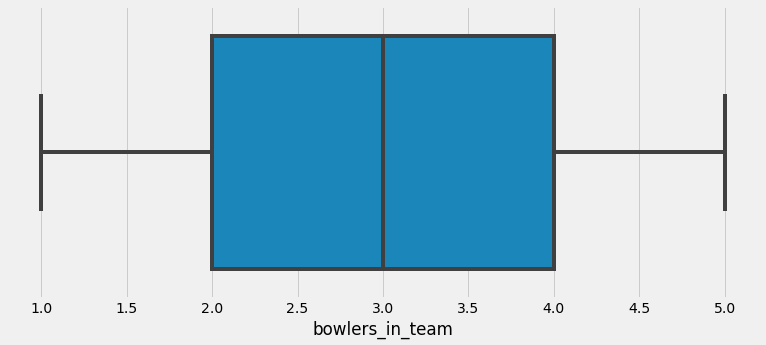

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



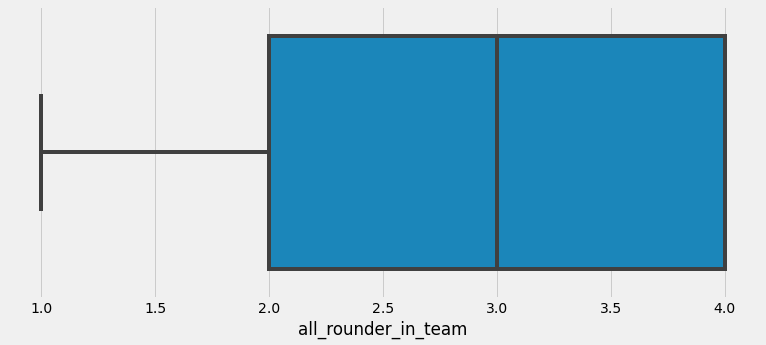

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

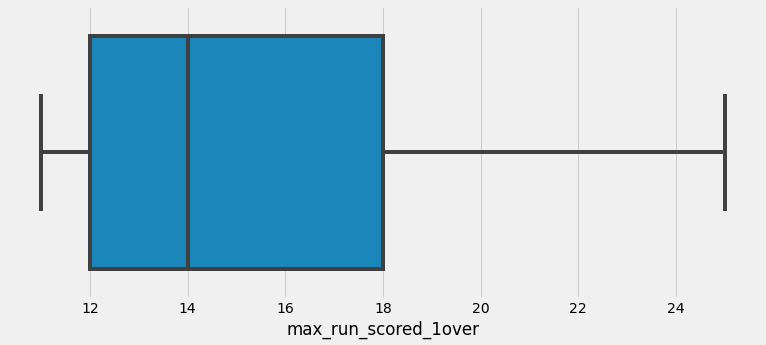

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



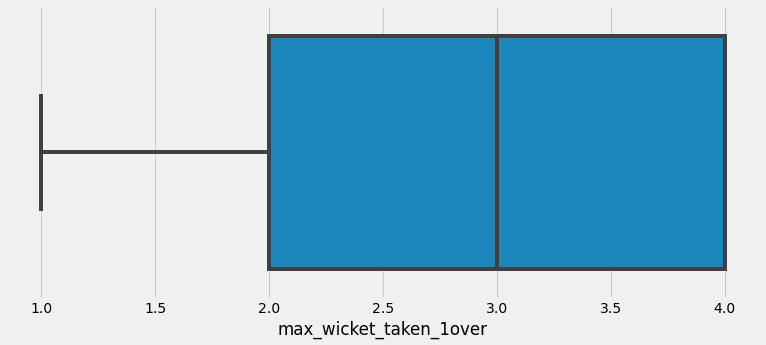

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



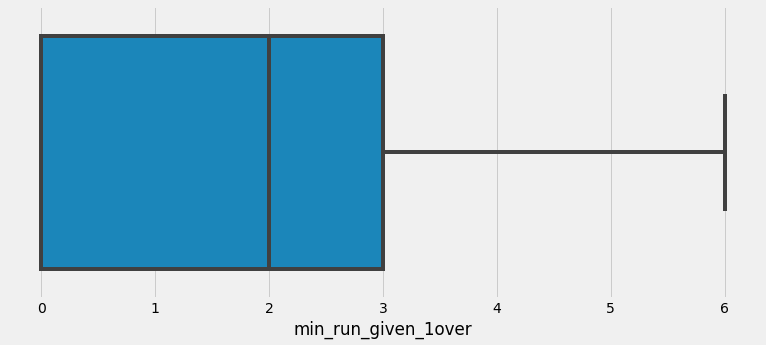

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



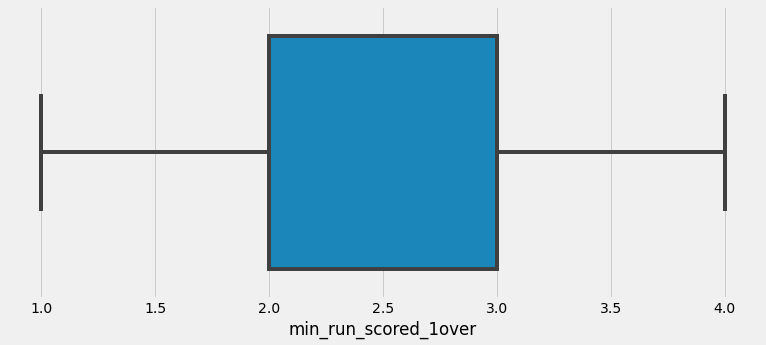

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



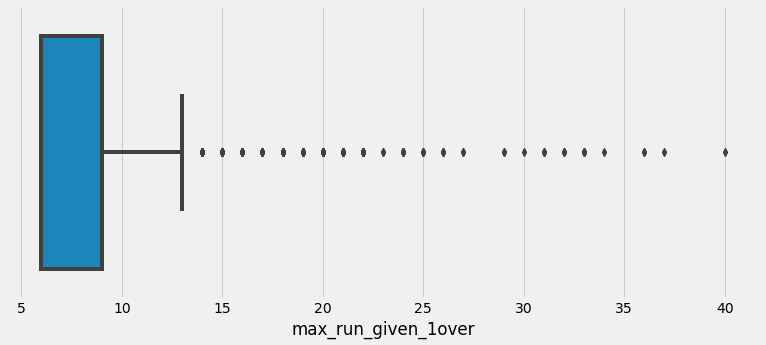

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



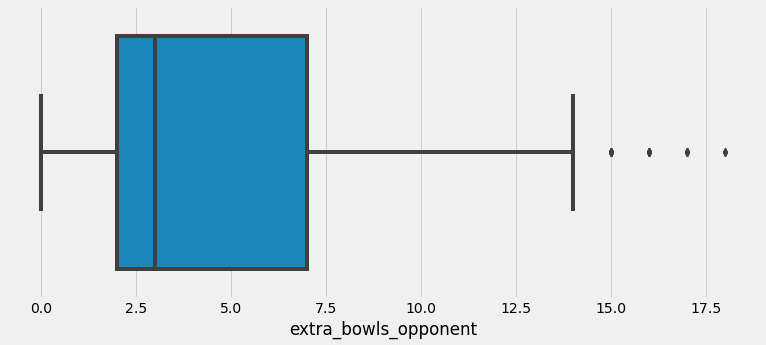

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



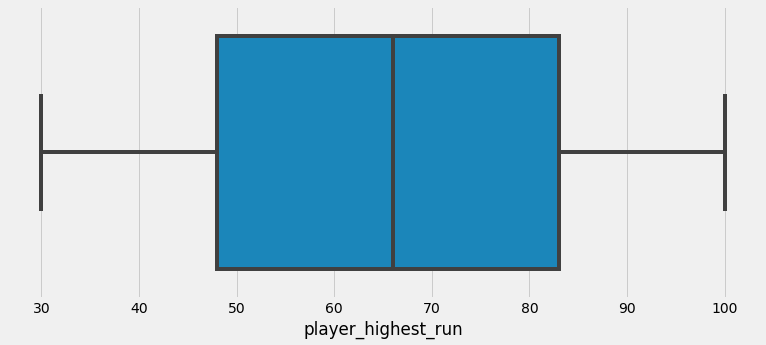

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



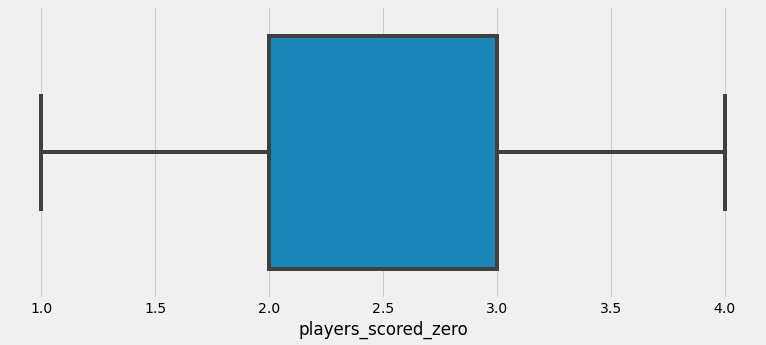

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



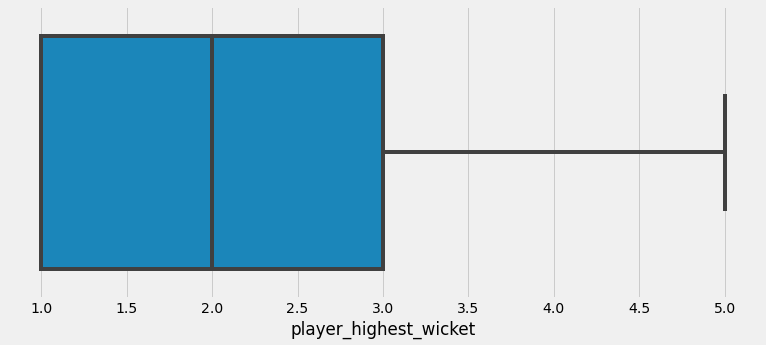

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



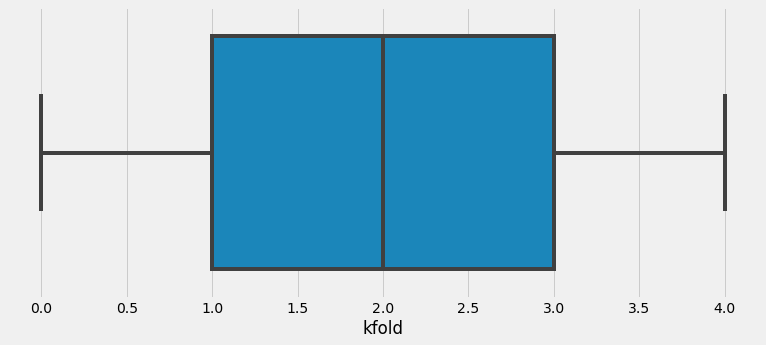

In [ ]:
for col in df_maindata.columns:
  plt.figure(figsize = (12,5))
  if df_maindata[col].dtype != 'object':
    sns.boxplot(df_maindata[col])
    plt.show()

## **Let's work with Cardinality**

In [ ]:
for col in df_maindata.columns:
  print(col)
  print(f"First 5 Unique Values: {df_maindata[col].unique()[:5]}")
  print(f"Number of unique values: {df_maindata[col].nunique()}")

  print('\n')

game_number
First 5 Unique Values: ['Game_1' 'Game_2' 'Game_3' 'Game_4' 'Game_5']
Number of unique values: 2894


result
First 5 Unique Values: ['Loss' 'Win']
Number of unique values: 2


avg_team_age
First 5 Unique Values: [24. 30. 25. 26. 27.]
Number of unique values: 7


match_light_type
First 5 Unique Values: ['Day' 'Day and Night' 'Night']
Number of unique values: 3


match_format
First 5 Unique Values: ['ODI' 'T20' 'Test']
Number of unique values: 3


bowlers_in_team
First 5 Unique Values: [3. 2. 1. 4. 5.]
Number of unique values: 5


all_rounder_in_team
First 5 Unique Values: [3. 4. 2. 1.]
Number of unique values: 4


first_selection
First 5 Unique Values: ['Bowling' 'Batting']
Number of unique values: 2


opponent
First 5 Unique Values: ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England']
Number of unique values: 9


season
First 5 Unique Values: ['Summer' 'Rainy' 'Winter']
Number of unique values: 3


offshore
First 5 Unique Values: ['No' 'Yes']
Number of unique values: 2


m

### **Observation:**

---
- We can One Hot Encode variables with 3 unique values
- Drop audience_number as it doesn't contribute much towards the predictions.


In [ ]:
useful_cols = [col for col in df_maindata.columns if col not in ['game_number', 'result', 'kfold']]
categorical = [col for col in useful_cols if df_maindata[col].dtype == 'object']
numerical = [col for col in useful_cols if col not in categorical]

In [ ]:
ohe_list = []
for col in df_maindata[useful_cols].columns:
  if df_maindata[useful_cols][col].nunique() <= 3:
    ohe_list.append(col) 

ohe_list

['match_light_type', 'match_format', 'first_selection', 'season', 'offshore']

In [ ]:
for col in ohe_list:
  dummies = pd.get_dummies(df_maindata[col], prefix=col)
  df_maindata[dummies.columns] = dummies

In [ ]:
df_maindata.drop(ohe_list, axis = 1, inplace=True )
df_maindata.drop('game_number', axis = 1, inplace=True)

In [ ]:
df_maindata['result'] = df_maindata['result'].apply(lambda x: 1 if x == 'Win' else 0)

In [ ]:
useful_cols = [col for col in df_maindata.columns if col not in ['game_number', 'result' ,'kfold']]
categorical = [col for col in useful_cols if df_maindata[col].dtype == 'object']
numerical = [col for col in useful_cols if col not in categorical]

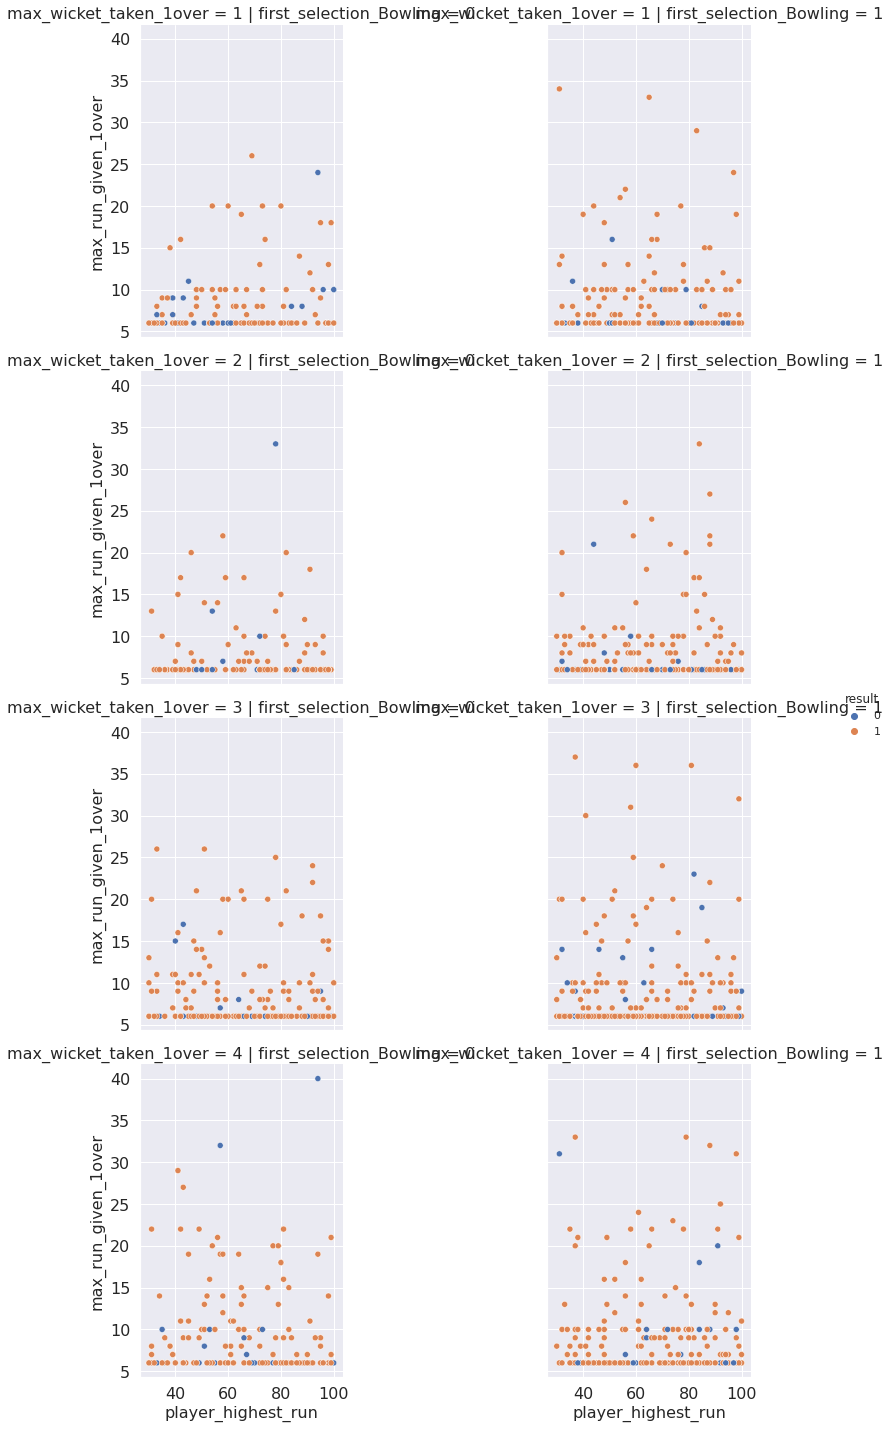

In [ ]:
sns.set(rc={'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16})
sns.relplot(x="player_highest_run", y="max_run_given_1over",col="first_selection_Bowling", row="max_wicket_taken_1over", hue='result',  data=df_maindata)
plt.show()

In [ ]:
for col in df_maindata.columns:
  print(col)
  print(f"First 5 Unique Values: {df_maindata[col].unique()[:5]}")
  print(f"Number of unique values: {df_maindata[col].nunique()}")

  print('\n')

result
First 5 Unique Values: [0 1]
Number of unique values: 2


avg_team_age
First 5 Unique Values: [24. 30. 25. 26. 27.]
Number of unique values: 7


bowlers_in_team
First 5 Unique Values: [3. 2. 1. 4. 5.]
Number of unique values: 5


all_rounder_in_team
First 5 Unique Values: [3. 4. 2. 1.]
Number of unique values: 4


opponent
First 5 Unique Values: ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England']
Number of unique values: 9


max_run_scored_1over
First 5 Unique Values: [13. 12. 14. 15. 16.]
Number of unique values: 15


max_wicket_taken_1over
First 5 Unique Values: [3 1 4 2]
Number of unique values: 4


min_run_given_1over
First 5 Unique Values: [2 0 5 4 3]
Number of unique values: 7


min_run_scored_1over
First 5 Unique Values: [3. 4. 1. 2.]
Number of unique values: 4


max_run_given_1over
First 5 Unique Values: [ 6.  7.  8.  9. 10.]
Number of unique values: 31


extra_bowls_opponent
First 5 Unique Values: [0 1 2 3 4]
Number of unique values: 19


player_highest_run
First 5 Un

In [ ]:
df, df_test1 = train_test_split(df_maindata, stratify=df_maindata['result'], test_size = 0.15, random_state = 7)

## **HyperTuning first Model**

In [ ]:
def run(trial):

    for fold in range(5):
        xtrain =  df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)

        ytrain = xtrain.result
        yvalid = xvalid.result
        
        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        ordinal_encoder = preprocessing.OrdinalEncoder()
        xtrain[categorical] = ordinal_encoder.fit_transform(xtrain[categorical])
        xvalid[categorical] = ordinal_encoder.transform(xvalid[categorical])
        
        # Optuna suggest params


        params = {
        'n_estimators': trial.suggest_int('n_estimators', 7000, 9000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.001)}
        
        model_xgb = XGBClassifier(**params, random_state=7)
        
        
        model_xgb.fit(xtrain, ytrain, early_stopping_rounds=300,eval_set=[(xvalid, yvalid)],  verbose=500)
        
        preds_valid = model_xgb.predict_proba(xvalid)[:, 1]
        roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    
        
    return roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

study.best_params

[I 2021-10-30 04:09:11,311] A new study created in memory with name: no-name-aa89e870-0565-40f5-bef3-a629744c042f


[0]	validation_0-error:0.161677
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.067864
[1000]	validation_0-error:0.063872
Stopping. Best iteration:
[705]	validation_0-error:0.061876

[0]	validation_0-error:0.158215
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.068966
[1000]	validation_0-error:0.075051
Stopping. Best iteration:
[788]	validation_0-error:0.066937

[0]	validation_0-error:0.147609
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060291
Stopping. Best iteration:
[461]	validation_0-error:0.058212

[0]	validation_0-error:0.129897
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041237
Stopping. Best iteration:
[662]	validation_0-error:0.035052

[0]	validation_0-error:0.160321
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046092
Stopping. Best iterat

[I 2021-10-30 04:09:23,977] Trial 0 finished with value: 0.9085292344786016 and parameters: {'n_estimators': 7868, 'max_depth': 4, 'learning_rate': 0.07516031292593624, 'subsample': 0.8174355593339853, 'colsample_bytree': 0.6878248331481365, 'gamma': 0.00046139554013342244}. Best is trial 0 with value: 0.9085292344786016.


[0]	validation_0-error:0.181637
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.097804
[1000]	validation_0-error:0.075848
[1500]	validation_0-error:0.065868
Stopping. Best iteration:
[1405]	validation_0-error:0.063872

[0]	validation_0-error:0.156187
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.091278
Stopping. Best iteration:
[656]	validation_0-error:0.073022

[0]	validation_0-error:0.158004
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.097713
[1000]	validation_0-error:0.070686
[1500]	validation_0-error:0.066528
Stopping. Best iteration:
[1231]	validation_0-error:0.064449

[0]	validation_0-error:0.150515
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.065979
[1000]	validation_0-error:0.045361
[1500]	validation_0-error:0.037113
Stopping. Best iteration:
[1563]	validation_0-error:0.03299

[0]	validati

[I 2021-10-30 04:09:51,431] Trial 1 finished with value: 0.9207655213984328 and parameters: {'n_estimators': 8168, 'max_depth': 5, 'learning_rate': 0.02137290063204793, 'subsample': 0.5244013020788083, 'colsample_bytree': 0.654447712564266, 'gamma': 0.0007809618399677284}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.147705
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.061876
Stopping. Best iteration:
[371]	validation_0-error:0.05988

[0]	validation_0-error:0.144016
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.064909
Stopping. Best iteration:
[586]	validation_0-error:0.060852

[0]	validation_0-error:0.147609
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06237
Stopping. Best iteration:
[458]	validation_0-error:0.06237

[0]	validation_0-error:0.148454
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.037113
Stopping. Best iteration:
[586]	validation_0-error:0.03299

[0]	validation_0-error:0.134269
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.042084
Stopping. Best iteration:
[457]	validation_0-error:0.042084



[I 2021-10-30 04:10:07,091] Trial 2 finished with value: 0.9146775165762507 and parameters: {'n_estimators': 8450, 'max_depth': 6, 'learning_rate': 0.03558157545423145, 'subsample': 0.8614381347340518, 'colsample_bytree': 0.8318052238900271, 'gamma': 0.0005013025456766226}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.149701
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.071856
Stopping. Best iteration:
[683]	validation_0-error:0.05988

[0]	validation_0-error:0.141988
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.073022
[1000]	validation_0-error:0.06288
Stopping. Best iteration:
[800]	validation_0-error:0.06288

[0]	validation_0-error:0.14553
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066528
Stopping. Best iteration:
[661]	validation_0-error:0.060291

[0]	validation_0-error:0.129897
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.051546
[1000]	validation_0-error:0.037113
Stopping. Best iteration:
[1081]	validation_0-error:0.03299

[0]	validation_0-error:0.122244
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.054108
[1000]	validation_0-error

[I 2021-10-30 04:10:29,305] Trial 3 finished with value: 0.9134418324291743 and parameters: {'n_estimators': 8186, 'max_depth': 6, 'learning_rate': 0.019997470663256262, 'subsample': 0.9342516597008071, 'colsample_bytree': 0.9123117683471338, 'gamma': 0.0009587990797624128}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.167665
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.065868
[1000]	validation_0-error:0.057884
Stopping. Best iteration:
[748]	validation_0-error:0.055888

[0]	validation_0-error:0.168357
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.058824
Stopping. Best iteration:
[508]	validation_0-error:0.056795

[0]	validation_0-error:0.151767
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.064449
Stopping. Best iteration:
[621]	validation_0-error:0.060291

[0]	validation_0-error:0.127835
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041237
Stopping. Best iteration:
[556]	validation_0-error:0.037113

[0]	validation_0-error:0.166333
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
Stopping. Best iteration:
[557]	validation_0-error:0.042

[I 2021-10-30 04:10:46,210] Trial 4 finished with value: 0.912959614225437 and parameters: {'n_estimators': 7926, 'max_depth': 6, 'learning_rate': 0.03761952521889646, 'subsample': 0.6783455840679485, 'colsample_bytree': 0.6473086746107726, 'gamma': 0.000777687751114629}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.149701
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.091816
[1000]	validation_0-error:0.071856
[1500]	validation_0-error:0.061876
Stopping. Best iteration:
[1326]	validation_0-error:0.05988

[0]	validation_0-error:0.15213
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.083164
Stopping. Best iteration:
[461]	validation_0-error:0.077079

[0]	validation_0-error:0.158004
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.081081
[1000]	validation_0-error:0.068607
Stopping. Best iteration:
[1109]	validation_0-error:0.060291

[0]	validation_0-error:0.142268
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.061856
[1000]	validation_0-error:0.043299
[1500]	validation_0-error:0.03299
Stopping. Best iteration:
[1473]	validation_0-error:0.03299

[0]	validation_0-error:0.136273
Will train until v

[I 2021-10-30 04:11:09,972] Trial 5 finished with value: 0.9099457504520796 and parameters: {'n_estimators': 8849, 'max_depth': 5, 'learning_rate': 0.019789876980349876, 'subsample': 0.9844161136094793, 'colsample_bytree': 0.9113801237249755, 'gamma': 0.0003900205279860972}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.161677
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.063872
Stopping. Best iteration:
[647]	validation_0-error:0.057884

[0]	validation_0-error:0.168357
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06288
[1000]	validation_0-error:0.06288
Stopping. Best iteration:
[708]	validation_0-error:0.058824

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066528
Stopping. Best iteration:
[550]	validation_0-error:0.06237

[0]	validation_0-error:0.131959
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.043299
[1000]	validation_0-error:0.037113
Stopping. Best iteration:
[787]	validation_0-error:0.035052

[0]	validation_0-error:0.170341
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046092
Stopping. Best iteration

[I 2021-10-30 04:11:24,271] Trial 6 finished with value: 0.9154611211573236 and parameters: {'n_estimators': 8954, 'max_depth': 5, 'learning_rate': 0.04292120583410323, 'subsample': 0.8956568225781207, 'colsample_bytree': 0.6636306815339297, 'gamma': 0.0009353295606538083}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.149701
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.101796
[1000]	validation_0-error:0.07984
[1500]	validation_0-error:0.073852
Stopping. Best iteration:
[1626]	validation_0-error:0.065868

[0]	validation_0-error:0.135903
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.095335
[1000]	validation_0-error:0.079108
[1500]	validation_0-error:0.070994
Stopping. Best iteration:
[1322]	validation_0-error:0.068966

[0]	validation_0-error:0.147609
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.097713
[1000]	validation_0-error:0.070686
[1500]	validation_0-error:0.064449
Stopping. Best iteration:
[1322]	validation_0-error:0.064449

[0]	validation_0-error:0.136082
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.080412
[1000]	validation_0-error:0.049485
Stopping. Best iteration:
[946]	valida

[I 2021-10-30 04:11:58,090] Trial 7 finished with value: 0.914798071127185 and parameters: {'n_estimators': 7329, 'max_depth': 5, 'learning_rate': 0.014311720984603888, 'subsample': 0.6206959870985113, 'colsample_bytree': 0.9353284071232044, 'gamma': 0.0004026821169587327}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.167665
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.127745
[1000]	validation_0-error:0.113772
[1500]	validation_0-error:0.103792
Stopping. Best iteration:
[1490]	validation_0-error:0.101796

[0]	validation_0-error:0.156187
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.119675
Stopping. Best iteration:
[411]	validation_0-error:0.111562

[0]	validation_0-error:0.158004
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.135135
[1000]	validation_0-error:0.118503
Stopping. Best iteration:
[814]	validation_0-error:0.114345

[0]	validation_0-error:0.138144
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.113402
[1000]	validation_0-error:0.101031
Stopping. Best iteration:
[787]	validation_0-error:0.096907

[0]	validation_0-error:0.152305
Will train until validation_0-error hasn't improved

[I 2021-10-30 04:12:12,335] Trial 8 finished with value: 0.8258288125376733 and parameters: {'n_estimators': 8575, 'max_depth': 3, 'learning_rate': 0.012995005379471625, 'subsample': 0.6276114768542783, 'colsample_bytree': 0.7836340711657463, 'gamma': 0.000645833070620568}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.169661
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.065868
Stopping. Best iteration:
[518]	validation_0-error:0.05988

[0]	validation_0-error:0.154158
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060852
Stopping. Best iteration:
[497]	validation_0-error:0.058824

[0]	validation_0-error:0.18711
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[185]	validation_0-error:0.064449

[0]	validation_0-error:0.142268
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.035052
Stopping. Best iteration:
[307]	validation_0-error:0.035052

[0]	validation_0-error:0.170341
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.042084
Stopping. Best iteration:
[366]	validation_0-error:0.042084



[I 2021-10-30 04:12:26,542] Trial 9 finished with value: 0.9161844484629293 and parameters: {'n_estimators': 7882, 'max_depth': 6, 'learning_rate': 0.07757764115270052, 'subsample': 0.5411955452896235, 'colsample_bytree': 0.8193480653590752, 'gamma': 0.0007107328128797807}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.175649
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.071856
Stopping. Best iteration:
[646]	validation_0-error:0.067864

[0]	validation_0-error:0.158215
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.077079
Stopping. Best iteration:
[441]	validation_0-error:0.066937

[0]	validation_0-error:0.16632
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06237
Stopping. Best iteration:
[551]	validation_0-error:0.058212

[0]	validation_0-error:0.152577
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041237
[1000]	validation_0-error:0.03299
Stopping. Best iteration:
[708]	validation_0-error:0.030928

[0]	validation_0-error:0.148297
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.0501
[1000]	validation_0-error:0.044088
Stopping. Best iteration:


[I 2021-10-30 04:12:39,939] Trial 10 finished with value: 0.9111211573236891 and parameters: {'n_estimators': 7379, 'max_depth': 4, 'learning_rate': 0.09728117390585386, 'subsample': 0.5002055904459859, 'colsample_bytree': 0.5303100920699598, 'gamma': 3.901048205424615e-05}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.167665
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.063872
Stopping. Best iteration:
[323]	validation_0-error:0.057884

[0]	validation_0-error:0.1643
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06288
Stopping. Best iteration:
[442]	validation_0-error:0.060852

[0]	validation_0-error:0.158004
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066528
Stopping. Best iteration:
[352]	validation_0-error:0.06237

[0]	validation_0-error:0.160825
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03299
Stopping. Best iteration:
[449]	validation_0-error:0.030928

[0]	validation_0-error:0.162325
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.042084
Stopping. Best iteration:
[326]	validation_0-error:0.042084



[I 2021-10-30 04:12:52,072] Trial 11 finished with value: 0.9106389391199519 and parameters: {'n_estimators': 7665, 'max_depth': 6, 'learning_rate': 0.06918058306672806, 'subsample': 0.5082985663011028, 'colsample_bytree': 0.5511701755588212, 'gamma': 0.0007389718971937648}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.181637
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057884
Stopping. Best iteration:
[508]	validation_0-error:0.053892

[0]	validation_0-error:0.15213
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.068966
Stopping. Best iteration:
[349]	validation_0-error:0.064909

[0]	validation_0-error:0.160083
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066528
Stopping. Best iteration:
[362]	validation_0-error:0.066528

[0]	validation_0-error:0.134021
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.037113
Stopping. Best iteration:
[485]	validation_0-error:0.035052

[0]	validation_0-error:0.164329
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
[1000]	validation_0-error:0.04008
Stopping. Best iteration:
[724]	validation_0-error:0.04008

[I 2021-10-30 04:13:06,464] Trial 12 finished with value: 0.9136528028933092 and parameters: {'n_estimators': 7021, 'max_depth': 5, 'learning_rate': 0.06512441501715308, 'subsample': 0.5715859648437246, 'colsample_bytree': 0.7536855122062727, 'gamma': 0.0006321344334566788}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.159681
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057884
Stopping. Best iteration:
[392]	validation_0-error:0.057884

[0]	validation_0-error:0.139959
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.073022
Stopping. Best iteration:
[338]	validation_0-error:0.066937

[0]	validation_0-error:0.158004
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060291
Stopping. Best iteration:
[641]	validation_0-error:0.056133

[0]	validation_0-error:0.14433
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.035052
Stopping. Best iteration:
[418]	validation_0-error:0.035052

[0]	validation_0-error:0.146293
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.042084
[1000]	validation_0-error:0.036072
Stopping. Best iteration:
[812]	validation_0-error:0.0360

[I 2021-10-30 04:13:18,776] Trial 13 finished with value: 0.907866184448463 and parameters: {'n_estimators': 8315, 'max_depth': 4, 'learning_rate': 0.09760704363678951, 'subsample': 0.7781995891637483, 'colsample_bytree': 0.8335312532862249, 'gamma': 0.0008299577070836573}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.189621
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[16]	validation_0-error:0.131737

[0]	validation_0-error:0.170385
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.109533
Stopping. Best iteration:
[572]	validation_0-error:0.10142

[0]	validation_0-error:0.164241
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[71]	validation_0-error:0.128898

[0]	validation_0-error:0.131959
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[19]	validation_0-error:0.103093

[0]	validation_0-error:0.170341
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.108216
[1000]	validation_0-error:0.094188
Stopping. Best iteration:
[1170]	validation_0-error:0.088176



[I 2021-10-30 04:13:31,545] Trial 14 finished with value: 0.8924653405666063 and parameters: {'n_estimators': 8091, 'max_depth': 6, 'learning_rate': 0.003207237649516151, 'subsample': 0.7082132920808446, 'colsample_bytree': 0.6002729326028826, 'gamma': 0.00021521299922832573}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.155689
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.055888
Stopping. Best iteration:
[524]	validation_0-error:0.051896

[0]	validation_0-error:0.160243
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06288
Stopping. Best iteration:
[424]	validation_0-error:0.058824

[0]	validation_0-error:0.149688
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066528
Stopping. Best iteration:
[597]	validation_0-error:0.06237

[0]	validation_0-error:0.134021
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039175
Stopping. Best iteration:
[558]	validation_0-error:0.035052

[0]	validation_0-error:0.146293
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.042084
Stopping. Best iteration:
[639]	validation_0-error:0.036072



[I 2021-10-30 04:13:49,195] Trial 15 finished with value: 0.9101567209162147 and parameters: {'n_estimators': 7704, 'max_depth': 5, 'learning_rate': 0.05453155291022344, 'subsample': 0.5764081216870898, 'colsample_bytree': 0.9945797246858218, 'gamma': 0.000603599389697579}. Best is trial 1 with value: 0.9207655213984328.


[0]	validation_0-error:0.181637
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.063872
Stopping. Best iteration:
[605]	validation_0-error:0.05988

[0]	validation_0-error:0.174442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06288
Stopping. Best iteration:
[488]	validation_0-error:0.060852

[0]	validation_0-error:0.160083
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06237
Stopping. Best iteration:
[275]	validation_0-error:0.058212

[0]	validation_0-error:0.142268
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.037113
Stopping. Best iteration:
[263]	validation_0-error:0.037113

[0]	validation_0-error:0.170341
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046092
Stopping. Best iteration:
[301]	validation_0-error:0.042084



[I 2021-10-30 04:14:02,684] Trial 16 finished with value: 0.924442435201929 and parameters: {'n_estimators': 8655, 'max_depth': 6, 'learning_rate': 0.07676937773621303, 'subsample': 0.5559749550891566, 'colsample_bytree': 0.7083063831664796, 'gamma': 0.0008300977628252686}. Best is trial 16 with value: 0.924442435201929.


[0]	validation_0-error:0.179641
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.083832
[1000]	validation_0-error:0.065868
Stopping. Best iteration:
[1082]	validation_0-error:0.05988

[0]	validation_0-error:0.160243
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.079108
[1000]	validation_0-error:0.068966
Stopping. Best iteration:
[796]	validation_0-error:0.066937

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.08316
Stopping. Best iteration:
[591]	validation_0-error:0.072765

[0]	validation_0-error:0.156701
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.061856
[1000]	validation_0-error:0.045361
[1500]	validation_0-error:0.039175
Stopping. Best iteration:
[1287]	validation_0-error:0.037113

[0]	validation_0-error:0.156313
Will train until validation_0-error hasn't improved 

[I 2021-10-30 04:14:19,472] Trial 17 finished with value: 0.910759493670886 and parameters: {'n_estimators': 8629, 'max_depth': 3, 'learning_rate': 0.0874594695585994, 'subsample': 0.6441244548338105, 'colsample_bytree': 0.7110793517351343, 'gamma': 0.000876100004015246}. Best is trial 16 with value: 0.924442435201929.


[0]	validation_0-error:0.179641
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.067864
[1000]	validation_0-error:0.061876
Stopping. Best iteration:
[893]	validation_0-error:0.055888

[0]	validation_0-error:0.170385
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06288
Stopping. Best iteration:
[555]	validation_0-error:0.056795

[0]	validation_0-error:0.160083
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.064449
Stopping. Best iteration:
[570]	validation_0-error:0.060291

[0]	validation_0-error:0.142268
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.037113
Stopping. Best iteration:
[566]	validation_0-error:0.03299

[0]	validation_0-error:0.160321
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
[1000]	validation_0-error:0.042084
Stopping. Best iteratio

[I 2021-10-30 04:14:34,713] Trial 18 finished with value: 0.9167269439421338 and parameters: {'n_estimators': 8643, 'max_depth': 5, 'learning_rate': 0.05155630942950681, 'subsample': 0.7267522617014351, 'colsample_bytree': 0.5985703658246075, 'gamma': 0.0009610086366020863}. Best is trial 16 with value: 0.924442435201929.


[0]	validation_0-error:0.177645
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.091816
Stopping. Best iteration:
[697]	validation_0-error:0.077844

[0]	validation_0-error:0.158215
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.093306
[1000]	validation_0-error:0.075051
Stopping. Best iteration:
[1068]	validation_0-error:0.068966

[0]	validation_0-error:0.162162
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.095634
[1000]	validation_0-error:0.070686
[1500]	validation_0-error:0.066528
Stopping. Best iteration:
[1278]	validation_0-error:0.064449

[0]	validation_0-error:0.154639
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.080412
[1000]	validation_0-error:0.043299
Stopping. Best iteration:
[1051]	validation_0-error:0.039175

[0]	validation_0-error:0.174349
Will train until validation_0-error hasn't improv

[I 2021-10-30 04:14:57,831] Trial 19 finished with value: 0.9136829415310429 and parameters: {'n_estimators': 8295, 'max_depth': 4, 'learning_rate': 0.0285223425761019, 'subsample': 0.5740357323386929, 'colsample_bytree': 0.7369669066538515, 'gamma': 0.0005337387825220406}. Best is trial 16 with value: 0.924442435201929.


[0]	validation_0-error:0.167665
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.061876
Stopping. Best iteration:
[398]	validation_0-error:0.05988

[0]	validation_0-error:0.166329
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.058824
Stopping. Best iteration:
[435]	validation_0-error:0.05071

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060291
Stopping. Best iteration:
[649]	validation_0-error:0.058212

[0]	validation_0-error:0.14433
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.035052
Stopping. Best iteration:
[378]	validation_0-error:0.03299

[0]	validation_0-error:0.180361
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
Stopping. Best iteration:
[404]	validation_0-error:0.042084



[I 2021-10-30 04:15:11,036] Trial 20 finished with value: 0.9201024713682942 and parameters: {'n_estimators': 8781, 'max_depth': 6, 'learning_rate': 0.05894391116178287, 'subsample': 0.7784897563947765, 'colsample_bytree': 0.606315703335559, 'gamma': 0.0008491532553124962}. Best is trial 16 with value: 0.924442435201929.


[0]	validation_0-error:0.167665
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.063872
Stopping. Best iteration:
[558]	validation_0-error:0.061876

[0]	validation_0-error:0.172414
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060852
Stopping. Best iteration:
[424]	validation_0-error:0.056795

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06237
Stopping. Best iteration:
[309]	validation_0-error:0.06237

[0]	validation_0-error:0.150515
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.030928
Stopping. Best iteration:
[306]	validation_0-error:0.030928

[0]	validation_0-error:0.174349
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
Stopping. Best iteration:
[265]	validation_0-error:0.044088



[I 2021-10-30 04:15:22,794] Trial 21 finished with value: 0.927335744424352 and parameters: {'n_estimators': 8819, 'max_depth': 6, 'learning_rate': 0.0592982016039167, 'subsample': 0.7841121520382168, 'colsample_bytree': 0.6123502038809282, 'gamma': 0.0008327772926904814}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.169661
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05988
[1000]	validation_0-error:0.057884
Stopping. Best iteration:
[750]	validation_0-error:0.057884

[0]	validation_0-error:0.174442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060852
Stopping. Best iteration:
[274]	validation_0-error:0.054767

[0]	validation_0-error:0.151767
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.064449
Stopping. Best iteration:
[263]	validation_0-error:0.064449

[0]	validation_0-error:0.138144
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.035052
Stopping. Best iteration:
[328]	validation_0-error:0.03299

[0]	validation_0-error:0.156313
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
Stopping. Best iteration:
[255]	validation_0-error:0.04408

[I 2021-10-30 04:15:34,175] Trial 22 finished with value: 0.9086799276672695 and parameters: {'n_estimators': 8462, 'max_depth': 6, 'learning_rate': 0.07914528502342642, 'subsample': 0.6704756307676498, 'colsample_bytree': 0.5014285759288465, 'gamma': 0.0007526776007217911}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.169661
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05988
Stopping. Best iteration:
[397]	validation_0-error:0.057884

[0]	validation_0-error:0.162272
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.068966
Stopping. Best iteration:
[369]	validation_0-error:0.06288

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06237
Stopping. Best iteration:
[698]	validation_0-error:0.058212

[0]	validation_0-error:0.136082
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03299
Stopping. Best iteration:
[397]	validation_0-error:0.03299

[0]	validation_0-error:0.176353
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04008
Stopping. Best iteration:
[397]	validation_0-error:0.04008



[I 2021-10-30 04:15:45,712] Trial 23 finished with value: 0.9090114526823387 and parameters: {'n_estimators': 8995, 'max_depth': 5, 'learning_rate': 0.06425489835710807, 'subsample': 0.8321214147141806, 'colsample_bytree': 0.6157945973657957, 'gamma': 0.000871337346860132}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.169661
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057884
Stopping. Best iteration:
[463]	validation_0-error:0.057884

[0]	validation_0-error:0.166329
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.056795
Stopping. Best iteration:
[484]	validation_0-error:0.056795

[0]	validation_0-error:0.151767
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060291
Stopping. Best iteration:
[441]	validation_0-error:0.060291

[0]	validation_0-error:0.14433
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03299
Stopping. Best iteration:
[432]	validation_0-error:0.03299

[0]	validation_0-error:0.172345
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
Stopping. Best iteration:
[679]	validation_0-error:0.042084



[I 2021-10-30 04:16:00,155] Trial 24 finished with value: 0.9208257986738999 and parameters: {'n_estimators': 8758, 'max_depth': 6, 'learning_rate': 0.04424705029834963, 'subsample': 0.7755343558841828, 'colsample_bytree': 0.6473715609738857, 'gamma': 0.0006842425654600678}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.159681
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.063872
Stopping. Best iteration:
[229]	validation_0-error:0.057884

[0]	validation_0-error:0.158215
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.054767
Stopping. Best iteration:
[267]	validation_0-error:0.054767

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.064449
Stopping. Best iteration:
[233]	validation_0-error:0.06237

[0]	validation_0-error:0.14433
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.035052
Stopping. Best iteration:
[322]	validation_0-error:0.035052

[0]	validation_0-error:0.180361
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
Stopping. Best iteration:
[211]	validation_0-error:0.044088



[I 2021-10-30 04:16:09,569] Trial 25 finished with value: 0.9194092827004219 and parameters: {'n_estimators': 8849, 'max_depth': 6, 'learning_rate': 0.0849993965441755, 'subsample': 0.777138935538396, 'colsample_bytree': 0.5602889013597793, 'gamma': 0.0006846476772946108}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.169661
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.065868
Stopping. Best iteration:
[608]	validation_0-error:0.053892

[0]	validation_0-error:0.170385
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.056795
Stopping. Best iteration:
[390]	validation_0-error:0.052738

[0]	validation_0-error:0.14553
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060291
Stopping. Best iteration:
[508]	validation_0-error:0.058212

[0]	validation_0-error:0.142268
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.035052
Stopping. Best iteration:
[409]	validation_0-error:0.035052

[0]	validation_0-error:0.154309
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.042084
Stopping. Best iteration:
[465]	validation_0-error:0.04008



[I 2021-10-30 04:16:24,585] Trial 26 finished with value: 0.9183242917420134 and parameters: {'n_estimators': 8750, 'max_depth': 6, 'learning_rate': 0.04880119309476588, 'subsample': 0.7286669416500177, 'colsample_bytree': 0.7049911408689716, 'gamma': 0.0005859179142731726}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.151697
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.051896
Stopping. Best iteration:
[450]	validation_0-error:0.0499

[0]	validation_0-error:0.158215
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.064909
Stopping. Best iteration:
[384]	validation_0-error:0.060852

[0]	validation_0-error:0.141372
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.06237
[1000]	validation_0-error:0.058212
Stopping. Best iteration:
[705]	validation_0-error:0.058212

[0]	validation_0-error:0.115464
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03299
Stopping. Best iteration:
[399]	validation_0-error:0.03299

[0]	validation_0-error:0.172345
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04008
Stopping. Best iteration:
[631]	validation_0-error:0.038076



[I 2021-10-30 04:16:39,955] Trial 27 finished with value: 0.911754068716094 and parameters: {'n_estimators': 8496, 'max_depth': 6, 'learning_rate': 0.04255194785537732, 'subsample': 0.8307745545832559, 'colsample_bytree': 0.7587524030957125, 'gamma': 0.0008939530513592076}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.157685
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.055888
Stopping. Best iteration:
[388]	validation_0-error:0.051896

[0]	validation_0-error:0.168357
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.056795
Stopping. Best iteration:
[553]	validation_0-error:0.054767

[0]	validation_0-error:0.160083
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060291
Stopping. Best iteration:
[470]	validation_0-error:0.060291

[0]	validation_0-error:0.140206
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.030928
Stopping. Best iteration:
[419]	validation_0-error:0.030928

[0]	validation_0-error:0.178357
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044088
Stopping. Best iteration:
[253]	validation_0-error:0.042084



[I 2021-10-30 04:16:52,227] Trial 28 finished with value: 0.9181133212778783 and parameters: {'n_estimators': 8704, 'max_depth': 6, 'learning_rate': 0.059172833391972164, 'subsample': 0.8780200544123449, 'colsample_bytree': 0.6389655901601207, 'gamma': 0.0009987933673809824}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.141717
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05988
Stopping. Best iteration:
[244]	validation_0-error:0.053892

[0]	validation_0-error:0.174442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.058824
Stopping. Best iteration:
[259]	validation_0-error:0.05071

[0]	validation_0-error:0.149688
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060291
Stopping. Best iteration:
[242]	validation_0-error:0.060291

[0]	validation_0-error:0.150515
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03299
Stopping. Best iteration:
[270]	validation_0-error:0.03299

[0]	validation_0-error:0.172345
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04008
Stopping. Best iteration:
[255]	validation_0-error:0.04008



[I 2021-10-30 04:17:02,378] Trial 29 finished with value: 0.9133212778782399 and parameters: {'n_estimators': 8380, 'max_depth': 6, 'learning_rate': 0.07185600436262371, 'subsample': 0.8012031778711954, 'colsample_bytree': 0.6814709642966094, 'gamma': 0.0008012706254680227}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.161677
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057884
Stopping. Best iteration:
[530]	validation_0-error:0.053892

[0]	validation_0-error:0.15213
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060852
Stopping. Best iteration:
[395]	validation_0-error:0.056795

[0]	validation_0-error:0.14553
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066528
Stopping. Best iteration:
[424]	validation_0-error:0.06237

[0]	validation_0-error:0.152577
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.037113
Stopping. Best iteration:
[323]	validation_0-error:0.03299

[0]	validation_0-error:0.168337
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04008
Stopping. Best iteration:
[436]	validation_0-error:0.04008



[I 2021-10-30 04:17:14,445] Trial 30 finished with value: 0.9081977094635323 and parameters: {'n_estimators': 8891, 'max_depth': 5, 'learning_rate': 0.08770506701430787, 'subsample': 0.7445669041865716, 'colsample_bytree': 0.713466689544284, 'gamma': 0.0002976056252296861}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.173653
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[80]	validation_0-error:0.139721

[0]	validation_0-error:0.150101
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[41]	validation_0-error:0.111562

[0]	validation_0-error:0.162162
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.128898
Stopping. Best iteration:
[695]	validation_0-error:0.126819

[0]	validation_0-error:0.150515
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[17]	validation_0-error:0.109278

[0]	validation_0-error:0.176353
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[88]	validation_0-error:0.12024



[I 2021-10-30 04:17:23,291] Trial 31 finished with value: 0.8251506931886678 and parameters: {'n_estimators': 8221, 'max_depth': 5, 'learning_rate': 0.0026649643885827447, 'subsample': 0.5395612533527836, 'colsample_bytree': 0.6733000595527544, 'gamma': 0.0006956245769681493}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.167665
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.067864
[1000]	validation_0-error:0.057884
Stopping. Best iteration:
[910]	validation_0-error:0.055888

[0]	validation_0-error:0.172414
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060852
Stopping. Best iteration:
[649]	validation_0-error:0.052738

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070686
[1000]	validation_0-error:0.06237
Stopping. Best iteration:
[731]	validation_0-error:0.06237

[0]	validation_0-error:0.14433
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.043299
Stopping. Best iteration:
[674]	validation_0-error:0.03299

[0]	validation_0-error:0.168337
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048096
[1000]	validation_0-error

[I 2021-10-30 04:17:41,572] Trial 32 finished with value: 0.9105485232067511 and parameters: {'n_estimators': 8561, 'max_depth': 6, 'learning_rate': 0.033196655729684825, 'subsample': 0.6986931348237665, 'colsample_bytree': 0.5765939669767581, 'gamma': 0.0007990771389740075}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.147705
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.067864
Stopping. Best iteration:
[655]	validation_0-error:0.061876

[0]	validation_0-error:0.154158
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066937
[1000]	validation_0-error:0.058824
Stopping. Best iteration:
[739]	validation_0-error:0.056795

[0]	validation_0-error:0.160083
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070686
Stopping. Best iteration:
[636]	validation_0-error:0.064449

[0]	validation_0-error:0.14433
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.045361
[1000]	validation_0-error:0.035052
Stopping. Best iteration:
[705]	validation_0-error:0.035052

[0]	validation_0-error:0.166333
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.052104
[1000]	validation_0-er

[I 2021-10-30 04:17:58,454] Trial 33 finished with value: 0.9143158529234479 and parameters: {'n_estimators': 8129, 'max_depth': 6, 'learning_rate': 0.026125566841689887, 'subsample': 0.9168433304441594, 'colsample_bytree': 0.6367926775805904, 'gamma': 0.0005032348580667056}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.175649
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.07984
[1000]	validation_0-error:0.063872
Stopping. Best iteration:
[1008]	validation_0-error:0.061876

[0]	validation_0-error:0.158215
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.081136
Stopping. Best iteration:
[629]	validation_0-error:0.073022

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070686
[1000]	validation_0-error:0.058212
Stopping. Best iteration:
[1032]	validation_0-error:0.056133

[0]	validation_0-error:0.134021
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.047423
[1000]	validation_0-error:0.041237
Stopping. Best iteration:
[1109]	validation_0-error:0.035052

[0]	validation_0-error:0.160321
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0

[I 2021-10-30 04:18:14,806] Trial 34 finished with value: 0.9039783001808318 and parameters: {'n_estimators': 8036, 'max_depth': 4, 'learning_rate': 0.0462824852690913, 'subsample': 0.8586898595345677, 'colsample_bytree': 0.6618655144732499, 'gamma': 0.0009216338209561555}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.181637
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05988
Stopping. Best iteration:
[404]	validation_0-error:0.05988

[0]	validation_0-error:0.172414
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066937
Stopping. Best iteration:
[541]	validation_0-error:0.06288

[0]	validation_0-error:0.158004
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066528
Stopping. Best iteration:
[512]	validation_0-error:0.06237

[0]	validation_0-error:0.140206
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.035052
Stopping. Best iteration:
[400]	validation_0-error:0.035052

[0]	validation_0-error:0.170341
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.042084
Stopping. Best iteration:
[654]	validation_0-error:0.04008



[I 2021-10-30 04:18:29,810] Trial 35 finished with value: 0.9096443640747438 and parameters: {'n_estimators': 8787, 'max_depth': 6, 'learning_rate': 0.0618823184123114, 'subsample': 0.6015378555379408, 'colsample_bytree': 0.634737092541017, 'gamma': 0.000772175054614782}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.143713
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.067864
[1000]	validation_0-error:0.05988
Stopping. Best iteration:
[892]	validation_0-error:0.05988

[0]	validation_0-error:0.148073
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.068966
Stopping. Best iteration:
[644]	validation_0-error:0.060852

[0]	validation_0-error:0.143451
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.066528
Stopping. Best iteration:
[539]	validation_0-error:0.060291

[0]	validation_0-error:0.14433
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.045361
[1000]	validation_0-error:0.037113
Stopping. Best iteration:
[740]	validation_0-error:0.035052

[0]	validation_0-error:0.176353
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.052104
[1000]	validation_0-erro

[I 2021-10-30 04:18:48,070] Trial 36 finished with value: 0.9102772754671489 and parameters: {'n_estimators': 8414, 'max_depth': 5, 'learning_rate': 0.03826507371789084, 'subsample': 0.669249733859681, 'colsample_bytree': 0.7887175707612829, 'gamma': 0.0006772822383328286}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.159681
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.061876
Stopping. Best iteration:
[578]	validation_0-error:0.05988

[0]	validation_0-error:0.156187
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.073022
[1000]	validation_0-error:0.064909
Stopping. Best iteration:
[755]	validation_0-error:0.064909

[0]	validation_0-error:0.153846
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060291
Stopping. Best iteration:
[620]	validation_0-error:0.058212

[0]	validation_0-error:0.121649
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.035052
Stopping. Best iteration:
[514]	validation_0-error:0.03299

[0]	validation_0-error:0.152305
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04008
Stopping. Best iteration:
[586]	validation_0-error:0.038076

[I 2021-10-30 04:19:01,600] Trial 37 finished with value: 0.9084538878842677 and parameters: {'n_estimators': 7735, 'max_depth': 5, 'learning_rate': 0.05634844374231149, 'subsample': 0.9734862423458532, 'colsample_bytree': 0.6958216549470823, 'gamma': 0.0005508310402064843}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.153693
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.071856
[1000]	validation_0-error:0.061876
Stopping. Best iteration:
[857]	validation_0-error:0.05988

[0]	validation_0-error:0.162272
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.073022
[1000]	validation_0-error:0.068966
Stopping. Best iteration:
[719]	validation_0-error:0.06288

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070686
[1000]	validation_0-error:0.064449
Stopping. Best iteration:
[804]	validation_0-error:0.064449

[0]	validation_0-error:0.152577
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.047423
[1000]	validation_0-error:0.035052
Stopping. Best iteration:
[778]	validation_0-error:0.03299

[0]	validation_0-error:0.162325
Will train until validation_0-error hasn't improved in 

[I 2021-10-30 04:19:24,205] Trial 38 finished with value: 0.9127185051235684 and parameters: {'n_estimators': 8939, 'max_depth': 6, 'learning_rate': 0.02177677171987914, 'subsample': 0.7579162540546696, 'colsample_bytree': 0.7310375562866241, 'gamma': 0.00044082475412746504}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.175649
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.103792
[1000]	validation_0-error:0.08982
[1500]	validation_0-error:0.081836
[2000]	validation_0-error:0.071856
Stopping. Best iteration:
[2117]	validation_0-error:0.067864

[0]	validation_0-error:0.156187
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.097363
[1000]	validation_0-error:0.073022
Stopping. Best iteration:
[895]	validation_0-error:0.073022

[0]	validation_0-error:0.180873
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.10395
[1000]	validation_0-error:0.081081
[1500]	validation_0-error:0.066528
Stopping. Best iteration:
[1410]	validation_0-error:0.066528

[0]	validation_0-error:0.150515
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.084536
[1000]	validation_0-error:0.05567
[1500]	validation_0-error:0.045361
Stoppi

[I 2021-10-30 04:19:57,107] Trial 39 finished with value: 0.9236889692585896 and parameters: {'n_estimators': 8553, 'max_depth': 6, 'learning_rate': 0.010191936604628344, 'subsample': 0.5465741709186595, 'colsample_bytree': 0.5794328161221081, 'gamma': 0.000837713577242557}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.167665
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.101796
[1000]	validation_0-error:0.085828
[1500]	validation_0-error:0.073852
Stopping. Best iteration:
[1541]	validation_0-error:0.06986

[0]	validation_0-error:0.170385
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.095335
[1000]	validation_0-error:0.075051
Stopping. Best iteration:
[989]	validation_0-error:0.070994

[0]	validation_0-error:0.160083
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.101871
[1000]	validation_0-error:0.076923
[1500]	validation_0-error:0.066528
Stopping. Best iteration:
[1256]	validation_0-error:0.066528

[0]	validation_0-error:0.146392
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.080412
[1000]	validation_0-error:0.051546
Stopping. Best iteration:
[1182]	validation_0-error:0.045361

[0]	validati

[I 2021-10-30 04:20:26,485] Trial 40 finished with value: 0.9200421940928271 and parameters: {'n_estimators': 8658, 'max_depth': 6, 'learning_rate': 0.011387504509335147, 'subsample': 0.5948271707718942, 'colsample_bytree': 0.5128771671437828, 'gamma': 0.0008323421295845697}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.159681
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.111776
[1000]	validation_0-error:0.093812
[1500]	validation_0-error:0.085828
Stopping. Best iteration:
[1336]	validation_0-error:0.085828

[0]	validation_0-error:0.1643
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.103448
[1000]	validation_0-error:0.083164
[1500]	validation_0-error:0.068966
[2000]	validation_0-error:0.064909
Stopping. Best iteration:
[1873]	validation_0-error:0.064909

[0]	validation_0-error:0.168399
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.112266
[1000]	validation_0-error:0.091476
[1500]	validation_0-error:0.081081
Stopping. Best iteration:
[1252]	validation_0-error:0.079002

[0]	validation_0-error:0.154639
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.090722
[1000]	validation_0-error:0.068041
[150

[I 2021-10-30 04:21:02,303] Trial 41 finished with value: 0.920192887281495 and parameters: {'n_estimators': 8534, 'max_depth': 6, 'learning_rate': 0.008381545929875604, 'subsample': 0.5409378309030406, 'colsample_bytree': 0.5792497204122267, 'gamma': 0.0007617882705714733}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.177645
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.093812
[1000]	validation_0-error:0.075848
[1500]	validation_0-error:0.065868
Stopping. Best iteration:
[1462]	validation_0-error:0.065868

[0]	validation_0-error:0.168357
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.085193
[1000]	validation_0-error:0.068966
Stopping. Best iteration:
[1177]	validation_0-error:0.064909

[0]	validation_0-error:0.149688
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.087318
[1000]	validation_0-error:0.070686
Stopping. Best iteration:
[1027]	validation_0-error:0.068607

[0]	validation_0-error:0.138144
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.059794
[1000]	validation_0-error:0.045361
[1500]	validation_0-error:0.037113
Stopping. Best iteration:
[1517]	validation_0-error:0.035052

[0]	valida

[I 2021-10-30 04:21:33,211] Trial 42 finished with value: 0.9214285714285715 and parameters: {'n_estimators': 8781, 'max_depth': 6, 'learning_rate': 0.017730945614394353, 'subsample': 0.5204097203809777, 'colsample_bytree': 0.6569123579728426, 'gamma': 0.000935713965813301}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.175649
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.085828
[1000]	validation_0-error:0.06986
[1500]	validation_0-error:0.063872
Stopping. Best iteration:
[1233]	validation_0-error:0.05988

[0]	validation_0-error:0.154158
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.079108
[1000]	validation_0-error:0.058824
Stopping. Best iteration:
[1012]	validation_0-error:0.056795

[0]	validation_0-error:0.182952
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.076923
[1000]	validation_0-error:0.068607
Stopping. Best iteration:
[836]	validation_0-error:0.066528

[0]	validation_0-error:0.140206
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.049485
Stopping. Best iteration:
[599]	validation_0-error:0.043299

[0]	validation_0-error:0.186373
Will train until validation_0-error hasn't improved 

[I 2021-10-30 04:21:57,074] Trial 43 finished with value: 0.9183242917420132 and parameters: {'n_estimators': 8825, 'max_depth': 6, 'learning_rate': 0.021648903481810648, 'subsample': 0.5509820572360362, 'colsample_bytree': 0.6199925256914958, 'gamma': 0.0009945297473971059}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.169661
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.0998
[1000]	validation_0-error:0.075848
[1500]	validation_0-error:0.067864
Stopping. Best iteration:
[1582]	validation_0-error:0.063872

[0]	validation_0-error:0.160243
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.083164
[1000]	validation_0-error:0.068966
[1500]	validation_0-error:0.054767
Stopping. Best iteration:
[1492]	validation_0-error:0.054767

[0]	validation_0-error:0.160083
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.095634
[1000]	validation_0-error:0.066528
[1500]	validation_0-error:0.064449
Stopping. Best iteration:
[1344]	validation_0-error:0.06237

[0]	validation_0-error:0.160825
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.068041
[1000]	validation_0-error:0.043299
[1500]	validation_0-error:0.037113
Stopp

[I 2021-10-30 04:22:27,107] Trial 44 finished with value: 0.9229957805907174 and parameters: {'n_estimators': 8722, 'max_depth': 6, 'learning_rate': 0.017185329815382944, 'subsample': 0.5102281006456677, 'colsample_bytree': 0.5375176476844129, 'gamma': 0.0009324951730688797}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.179641
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.111776
[1000]	validation_0-error:0.095808
[1500]	validation_0-error:0.085828
Stopping. Best iteration:
[1370]	validation_0-error:0.085828

[0]	validation_0-error:0.172414
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.107505
[1000]	validation_0-error:0.087221
[1500]	validation_0-error:0.073022
[2000]	validation_0-error:0.066937
[2500]	validation_0-error:0.058824
Stopping. Best iteration:
[2399]	validation_0-error:0.058824

[0]	validation_0-error:0.160083
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.112266
[1000]	validation_0-error:0.095634
[1500]	validation_0-error:0.081081
[2000]	validation_0-error:0.068607
Stopping. Best iteration:
[1888]	validation_0-error:0.068607

[0]	validation_0-error:0.162887
Will train until validation_0-error hasn't improved in 300 rounds.
[

[I 2021-10-30 04:23:05,006] Trial 45 finished with value: 0.9194695599758891 and parameters: {'n_estimators': 8903, 'max_depth': 6, 'learning_rate': 0.009101596435863751, 'subsample': 0.5011213352237023, 'colsample_bytree': 0.5379088068753924, 'gamma': 0.0009183639951053198}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.167665
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.095808
[1000]	validation_0-error:0.083832
[1500]	validation_0-error:0.067864
Stopping. Best iteration:
[1608]	validation_0-error:0.065868

[0]	validation_0-error:0.162272
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.089249
[1000]	validation_0-error:0.064909
Stopping. Best iteration:
[1042]	validation_0-error:0.06288

[0]	validation_0-error:0.147609
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.097713
[1000]	validation_0-error:0.074844
[1500]	validation_0-error:0.066528
Stopping. Best iteration:
[1263]	validation_0-error:0.066528

[0]	validation_0-error:0.154639
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.068041
[1000]	validation_0-error:0.045361
Stopping. Best iteration:
[894]	validation_0-error:0.045361

[0]	validati

[I 2021-10-30 04:23:33,501] Trial 46 finished with value: 0.9185955394816155 and parameters: {'n_estimators': 9000, 'max_depth': 6, 'learning_rate': 0.015571108257123146, 'subsample': 0.5229042523714541, 'colsample_bytree': 0.5788626447160071, 'gamma': 0.0009556003023499216}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.157685
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.093812
[1000]	validation_0-error:0.077844
[1500]	validation_0-error:0.061876
Stopping. Best iteration:
[1451]	validation_0-error:0.061876

[0]	validation_0-error:0.174442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.083164
[1000]	validation_0-error:0.066937
[1500]	validation_0-error:0.06288
Stopping. Best iteration:
[1613]	validation_0-error:0.056795

[0]	validation_0-error:0.16632
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.093555
[1000]	validation_0-error:0.068607
Stopping. Best iteration:
[1121]	validation_0-error:0.064449

[0]	validation_0-error:0.154639
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.068041
[1000]	validation_0-error:0.047423
Stopping. Best iteration:
[874]	validation_0-error:0.045361

[0]	validatio

[I 2021-10-30 04:24:01,128] Trial 47 finished with value: 0.9211573236889692 and parameters: {'n_estimators': 8591, 'max_depth': 6, 'learning_rate': 0.017346866929237148, 'subsample': 0.5615133766672714, 'colsample_bytree': 0.5254806003285626, 'gamma': 0.0008910471142489273}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.165669
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.083832
Stopping. Best iteration:
[649]	validation_0-error:0.067864

[0]	validation_0-error:0.170385
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.068966
[1000]	validation_0-error:0.056795
Stopping. Best iteration:
[971]	validation_0-error:0.054767

[0]	validation_0-error:0.143451
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.081081
[1000]	validation_0-error:0.06237
Stopping. Best iteration:
[927]	validation_0-error:0.06237

[0]	validation_0-error:0.158763
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.049485
Stopping. Best iteration:
[599]	validation_0-error:0.045361

[0]	validation_0-error:0.162325
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.062124
[1000]	validation_0-err

[I 2021-10-30 04:24:21,780] Trial 48 finished with value: 0.9187763713080169 and parameters: {'n_estimators': 8662, 'max_depth': 6, 'learning_rate': 0.025145968744229297, 'subsample': 0.5256963741586314, 'colsample_bytree': 0.5714500495308565, 'gamma': 0.0008244295599454475}. Best is trial 21 with value: 0.927335744424352.


[0]	validation_0-error:0.171657
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[66]	validation_0-error:0.159681

[0]	validation_0-error:0.162272
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.135903
[1000]	validation_0-error:0.119675
Stopping. Best iteration:
[931]	validation_0-error:0.119675

[0]	validation_0-error:0.155925
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[1]	validation_0-error:0.151767

[0]	validation_0-error:0.160825
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[12]	validation_0-error:0.119588

[0]	validation_0-error:0.156313
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.138277
Stopping. Best iteration:
[277]	validation_0-error:0.136273



[I 2021-10-30 04:24:28,475] Trial 49 finished with value: 0.8041139240506329 and parameters: {'n_estimators': 8356, 'max_depth': 3, 'learning_rate': 0.005299882585187269, 'subsample': 0.6018570731951622, 'colsample_bytree': 0.5527576336544855, 'gamma': 0.000955789745543698}. Best is trial 21 with value: 0.927335744424352.


{'colsample_bytree': 0.6123502038809282,
 'gamma': 0.0008327772926904814,
 'learning_rate': 0.0592982016039167,
 'max_depth': 6,
 'n_estimators': 8819,
 'subsample': 0.7841121520382168}

In [ ]:

df_test = df_test1[useful_cols]
final_test_predictions = []
final_valid_predictions = {}
decisions_valid = []
decisions_test = [] 
scores = []
for fold in range(5):
    xtrain =  df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test1.copy()
    
    valid_ids = xvalid.index.values.tolist()

    ytrain = xtrain.result
    yvalid = xvalid.result
    
    xtrain = xtrain[useful_cols]
    xvalid = xvalid[useful_cols]
    xtest = xtest[useful_cols]
    
    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[categorical] = ordinal_encoder.fit_transform(xtrain[categorical])
    xvalid[categorical] = ordinal_encoder.transform(xvalid[categorical])
    xtest[categorical] = ordinal_encoder.transform(xtest[categorical])
    
    params = study.best_params
    
    
    model = XGBClassifier(n_estimators=2000,
        random_state=7
    )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=500)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    # decision_valid = (preds_valid >= 0.5)
    # decisions_valid.append(decision_valid)
    test_preds = model.predict_proba(xtest)[:, 1]
    # decision_test = (test_preds >= 0.5)
    # decisions_test.append(decision_test)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc)
    scores.append(roc_auc)
 
print(np.mean(scores), np.std(scores))

[0]	validation_0-error:0.159681
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.081836
[1000]	validation_0-error:0.067864
Stopping. Best iteration:
[988]	validation_0-error:0.065868

0 0.9128115786652372
[0]	validation_0-error:0.144016
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.085193
[1000]	validation_0-error:0.073022
Stopping. Best iteration:
[1123]	validation_0-error:0.068966

1 0.9186144072875465
[0]	validation_0-error:0.162162
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.076923
[1000]	validation_0-error:0.068607
Stopping. Best iteration:
[721]	validation_0-error:0.066528

2 0.8894014962593516
[0]	validation_0-error:0.136082
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05567
[1000]	validation_0-error:0.045361
Stopping. Best iteration:
[852]	validation_0-error:0.043299

3 0.9316730997624703


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
df_test[categorical] = ordinal_encoder.transform(df_test[categorical])
print(confusion_matrix(df_test1.result, model.predict(df_test)))
print(classification_report(df_test1.result, model.predict(df_test)))

[[ 55  15]
 [  5 360]]
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        70
           1       0.96      0.99      0.97       365

    accuracy                           0.95       435
   macro avg       0.94      0.89      0.91       435
weighted avg       0.95      0.95      0.95       435



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



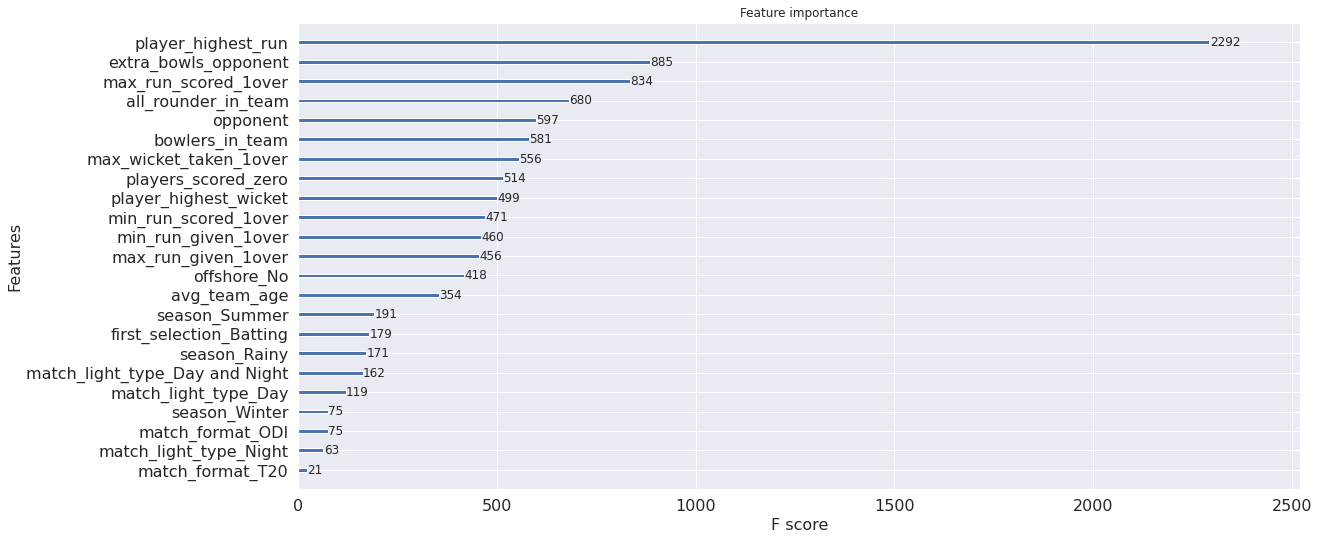

In [ ]:
import xgboost as xgb
model.get_booster().feature_names = list(useful_cols)
xgb.plot_importance(model.get_booster())

In [ ]:
from sklearn.ensemble import  RandomForestClassifier

In [ ]:
def run(trial):

    for fold in range(5):
        xtrain =  df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)

        ytrain = xtrain.result
        yvalid = xvalid.result
        
        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        ordinal_encoder = preprocessing.OrdinalEncoder()
        xtrain[categorical] = ordinal_encoder.fit_transform(xtrain[categorical])
        xvalid[categorical] = ordinal_encoder.transform(xvalid[categorical])
        
        # Optuna suggest params
        params = {
        'n_estimators':  trial.suggest_int("n_estimators", 2, 7000),
        'max_depth': int(trial.suggest_loguniform('max_depth', 1, 32))}


        
        model_rf = RandomForestClassifier(**params, random_state=7)
        
        
        model_rf.fit(xtrain, ytrain)
        
        preds_valid = model_rf.predict_proba(xvalid)[:, 1]
        roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    
        
    return roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=30)

study.best_params

[I 2021-10-30 04:28:50,936] A new study created in memory with name: no-name-ac435198-4dab-4d2e-b782-27d9a71300ab
[I 2021-10-30 04:28:54,162] Trial 0 finished with value: 0.8149186256781195 and parameters: {'n_estimators': 326, 'max_depth': 3.98733842445194}. Best is trial 0 with value: 0.8149186256781195.
[I 2021-10-30 04:29:20,211] Trial 1 finished with value: 0.8061482820976491 and parameters: {'n_estimators': 3108, 'max_depth': 1.568869375916347}. Best is trial 0 with value: 0.8149186256781195.
[I 2021-10-30 04:30:21,333] Trial 2 finished with value: 0.8282399035563592 and parameters: {'n_estimators': 6001, 'max_depth': 4.586504375665817}. Best is trial 2 with value: 0.8282399035563592.
[I 2021-10-30 04:31:13,835] Trial 3 finished with value: 0.8189572031344183 and parameters: {'n_estimators': 5486, 'max_depth': 3.6822307402605743}. Best is trial 2 with value: 0.8282399035563592.
[I 2021-10-30 04:32:05,646] Trial 4 finished with value: 0.894122965641953 and parameters: {'n_estimato

{'max_depth': 31.939959712387637, 'n_estimators': 103}

In [ ]:

df_test = df_test1[useful_cols]
final_test_predictions = []
final_valid_predictions = {}
decisions_valid = []
decisions_test = [] 
scores = []
for fold in range(5):
    xtrain =  df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()
    
    valid_ids = xvalid.index.values.tolist()

    ytrain = xtrain.result
    yvalid = xvalid.result
    
    xtrain = xtrain[useful_cols]
    xvalid = xvalid[useful_cols]
    
    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[categorical] = ordinal_encoder.fit_transform(xtrain[categorical])
    xvalid[categorical] = ordinal_encoder.transform(xvalid[categorical])
    xtest[categorical] = ordinal_encoder.transform(xtest[categorical])
    
    model = RandomForestClassifier(
        random_state=7, 
        n_estimators=103,
        max_depth = int(31.939959712387637)
    )
    model.fit(xtrain, ytrain)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    # decision_valid = (preds_valid >= 0.5)
    # decisions_valid.append(decision_valid)
    test_preds = model.predict_proba(xtest)[:, 1]
    # decision_test = (test_preds >= 0.5)
    # decisions_test.append(decision_test)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc)
    scores.append(roc_auc)
 
print(np.mean(scores), np.std(scores))

0 0.9409273653176092
1 0.9552918614407288
2 0.9519014962593516
3 0.9654468527315915
4 0.9530892103676913
0.9533313572233946 0.007830593347509926


<Figure size 1296x864 with 0 Axes>

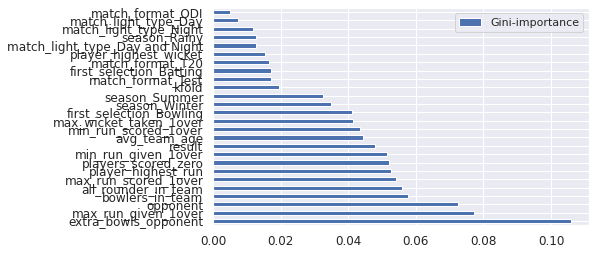

In [ ]:
import pandas as pd
%matplotlib inline
plt.figure(figsize = (18,12))
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df_maindata.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
(importances.sort_values(by='Gini-importance', ascending = False)).plot(kind='barh')

## **Test on the Given Series Condition:**

###  **1 Test match with England in England. All the match are day matches. In England, it will be rainy season at the time to match**


In [ ]:
"""Opponent as england in Label Encoder is 2.0"""

"""1 Test match with England in England. All the match are day matches. In England, it will be rainy season at the time to match. """
df_query = df_test.head(1)
df_query['opponent'] = ordinal_encoder.transform(np.array(['England']).reshape(-1,1))
df_query['match_format_Test'] = 1
df_query['season_Rainy'] = 1
df_query['match_light_type_Day and Night'] = 0
df_query['match_format_T20'] = 0
df_query['offshore_No'] = 0
df_query['offshore_Yes'] = 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
# df_query['opponent'] = ordinal_encoder.transform(df_query['opponent'].values.reshape(-1,1))
model.predict(df_query)

array([1])

## **2 T20 match with Australia in India. All the match are Day and Night matches. In India, it will be winter season at the time to match.**

In [ ]:
"""2 T20 match with Australia in India. All the match are Day and Night matches. In India, it will be winter season at the time to match. """
df_query = df_test.head(1)
df_query['opponent'] = ordinal_encoder.transform(np.array(['Australia']).reshape(-1,1))
df_query['season_Rainy'] = 0
df_query['season_Winter'] = 1
df_query['match_light_type_Day and Night'] = 1
df_query['match_format_Test'] = 0
df_query['offshore_No'] = 1
df_query['offshore_Yes'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
df_query.to_dict(orient='records')

[{'all_rounder_in_team': 4.0,
  'avg_team_age': 30.0,
  'bowlers_in_team': 2.0,
  'extra_bowls_opponent': 2,
  'first_selection_Batting': 0,
  'first_selection_Bowling': 1,
  'match_format_ODI': 0,
  'match_format_T20': 1,
  'match_format_Test': 0,
  'match_light_type_Day': 0,
  'match_light_type_Day and Night': 1,
  'match_light_type_Night': 0,
  'max_run_given_1over': 6.0,
  'max_run_scored_1over': 11.0,
  'max_wicket_taken_1over': 4,
  'min_run_given_1over': 0,
  'min_run_scored_1over': 3.0,
  'offshore_No': 1,
  'offshore_Yes': 0,
  'opponent': 0.0,
  'player_highest_run': 54.0,
  'player_highest_wicket': 2,
  'players_scored_zero': 3,
  'season_Rainy': 0,
  'season_Summer': 0,
  'season_Winter': 1}]

In [ ]:
model.predict(df_query)

array([1])

In [ ]:
df_query.to_dict(orient='records')

[{'all_rounder_in_team': 4.0,
  'avg_team_age': 30.0,
  'bowlers_in_team': 2.0,
  'extra_bowls_opponent': 2,
  'first_selection_Batting': 0,
  'first_selection_Bowling': 1,
  'match_format_ODI': 0,
  'match_format_T20': 1,
  'match_format_Test': 0,
  'match_light_type_Day': 0,
  'match_light_type_Day and Night': 1,
  'match_light_type_Night': 0,
  'max_run_given_1over': 6.0,
  'max_run_scored_1over': 11.0,
  'max_wicket_taken_1over': 4,
  'min_run_given_1over': 0,
  'min_run_scored_1over': 3.0,
  'offshore_No': 1,
  'offshore_Yes': 0,
  'opponent': 0.0,
  'player_highest_run': 54.0,
  'player_highest_wicket': 2,
  'players_scored_zero': 3,
  'season_Rainy': 0,
  'season_Summer': 0,
  'season_Winter': 1}]

### **2 ODI match with Sri Lanka in India. All the match are Day and Night matches. In India, it will be winter season at the time to match.**

In [ ]:
#  2 ODI match with Sri Lanka in India. All the match are Day and Night matches. In India, it will be winter season at the time to match.
df_query = df_test.head(1)
df_query['opponent'] = ordinal_encoder.transform(np.array(['Srilanka']).reshape(-1,1))
df_query['match_format_ODI'] = 1
df_query['match_format_T20'] = 0
df_query['season_Rainy'] = 0
df_query['season_Winter'] = 1
df_query['match_light_type_Day and Night'] = 1
df_query['match_format_Test'] = 0
df_query['offshore_No'] = 1
df_query['offshore_Yes'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
model.predict(df_query)

array([1])

In [ ]:
df_query.to_dict(orient='records')

[{'all_rounder_in_team': 4.0,
  'avg_team_age': 30.0,
  'bowlers_in_team': 2.0,
  'extra_bowls_opponent': 2,
  'first_selection_Batting': 0,
  'first_selection_Bowling': 1,
  'match_format_ODI': 1,
  'match_format_T20': 0,
  'match_format_Test': 0,
  'match_light_type_Day': 0,
  'match_light_type_Day and Night': 1,
  'match_light_type_Night': 0,
  'max_run_given_1over': 6.0,
  'max_run_scored_1over': 11.0,
  'max_wicket_taken_1over': 4,
  'min_run_given_1over': 0,
  'min_run_scored_1over': 3.0,
  'offshore_No': 1,
  'offshore_Yes': 0,
  'opponent': 6.0,
  'player_highest_run': 54.0,
  'player_highest_wicket': 2,
  'players_scored_zero': 3,
  'season_Rainy': 0,
  'season_Summer': 0,
  'season_Winter': 1}]